In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
np.random.seed(1976)
tf.random.set_seed(1976)

2022-07-26 17:23:07.418911: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-26 17:23:07.418939: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import subprocess
##======================
dim = 3            ## dimensiom
L=2                   ## number of fidelity levels
##======================
import trieste
from trieste.space import Box

search_space = trieste.space.Box(
    [0.1, 0.01, -0.1],
    [2.5, 1.00, 2.0]
)
##=========================
from scipy.optimize import Bounds
# bounds_acq=Bounds(search_space.lower.numpy(), search_space.upper.numpy()) ## the bounds to maximize the acquisition function
bounds_acq=[(0.1,2.5),(0.01,1),(-0.1,2)]
##=================
## the weight of each fidelity level
W=np.ones(L)
W[0]=1.6
W[1]=2.6


##===========================
class Sim:
    
    threshold = 0.5

    @staticmethod
    def objective_1(input_data):
        
        x = input_data[:]
        if isinstance(x,np.ndarray):
            size=x.shape[0] 
        else:
            size = x.get_shape()[0] 
            
        sim_value = np.zeros(size)
        
        for i in range(size):
        
            f_out = open("design_vector_0.dat", "w")
            f_out.write(str(dim))
            f_out.write("\n")
            np.savetxt(f_out, x[i])
            f_out.close()
        
            subprocess.run(["./run_coarse.sh"])
        
            f_in = open("simulation_result_0.dat", "r")
            line1 = f_in.readline()
            line2 = f_in.readline()
            line3 = f_in.readline()
            sim_number = int(line1)
            sim_flag = int(line2)
            sim_value[i] = float(line3)
        
        return sim_value[:, None]

    def objective_2(input_data):
        
        x = input_data[:]
        if isinstance(x,np.ndarray):
            size=x.shape[0] 
        else:
            size = x.get_shape()[0] 
        sim_value = np.zeros(size)
        
        for i in range(size):
        
            f_out = open("design_vector_0.dat", "w")
            f_out.write(str(dim))
            f_out.write("\n")
            np.savetxt(f_out, x[i])
            f_out.close()
        
            subprocess.run(["./run_fine.sh"])
        
            f_in = open("simulation_result_0.dat", "r")
            line1 = f_in.readline()
            line2 = f_in.readline()
            line3 = f_in.readline()
            sim_number = int(line1)
            sim_flag = int(line2)
            sim_value[i] = float(line3)
        
        return sim_value[:, None]
 
    
    @staticmethod
    def constraint(input_data):
        
        x = input_data[:]
        size = x.get_shape()[0]
        const_value = np.zeros(size)
        
        for i in range(size):
        
            const_value[i] = x[i,1]
        
        return const_value[:, None]


In [3]:
## number of initial points
n=[12,4]
##==============================
initial_query_points=[]
for i in range(L):
    initial_query_points.append(search_space.sample(n[i]))
##==============================
from trieste.data import Dataset

OBJECTIVE = "OBJECTIVE"

def observer_1(query_points):
    return {
        OBJECTIVE: Dataset(query_points, Sim.objective_1(query_points  )),     
    }

def observer_2(query_points):
    return {
        OBJECTIVE: Dataset(query_points, Sim.objective_2(query_points)),
    }
observer=[observer_1, observer_2]
initial_data_1=observer[0](initial_query_points[0])
initial_data_2=observer[1](initial_query_points[1])
initial_data=[initial_data_1, initial_data_2]

2022-07-26 17:24:15.616792: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-26 17:24:15.616848: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (macaron): /proc/driver/nvidia/version does not exist


## Data Normalization

In [5]:
def normalization(observations):
    Y_max=np.max(observations)
    Y_min=np.min(observations)
    return (observations-1/2*(Y_max+Y_min))/(1/2*(Y_max-Y_min)) 

data_X=[initial_data_1[OBJECTIVE].query_points[:].numpy().reshape(n[0],dim),initial_data_2[OBJECTIVE].query_points[:].numpy().reshape(n[1],dim)]
Y=[initial_data_1[OBJECTIVE].observations[:].reshape(n[0],1) ,initial_data_2[OBJECTIVE].observations[:].reshape(n[1],1)] 
data_Y=[normalization(Y[0]) ,normalization(Y[1])]
sigma_epsilon=[_,_]
models=[_,_]
k=[_,_]
k_inv=[_,_]
Y_max=[np.max(Y[0]),np.max(Y[1])]
Y_min=[np.min(Y[0]),np.min(Y[1])]

## Building the model 

## coarse model

In [6]:
## squared exponential kernel 
lengthscales=[1]*dim
k[0]=gpflow.kernels.RBF(1,lengthscales)+gpflow.kernels.Constant()
models[0]=gpflow.models.GPR((data_X[0], data_Y[0]),k1,noise_variance=1e-5)
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model1.training_loss,variables=model1.trainable_variables,options=dict(disp=True, maxiter=100)) 


sigma_epsilon[0]=np.sqrt(float(models[0].likelihood.variance.numpy()))
k_inv[0]=np.linalg.inv(k[0](data_X[0])+sigma_epsilon[0]**2*np.eye(n[0]))
def K_c(x):
    
  
    K=k[0](x,data_X[0])

       
    return K.numpy().T


def k_coef_c(x):
    if x.shape[0]==1:
        return k[0](x,x).numpy()
    else :
        return k[0](x,x).numpy().diagonal().reshape((x.shape[0],1))
    
def predict_c(x):
    mean=np.dot(K_c(x).T,np.dot(k_inv[0],data_Y[0]))## Y
    if x.shape[0]==1:
        var=k_coef_c(x)+sigma_epsilon[0]**2-np.dot(K_c(x).T,np.dot(k_inv[0],K_c(x))).reshape(x.shape[0],1)
    else:
        var=k_coef_c(x)+sigma_epsilon[0]**2-np.dot(K_c(x).T,np.dot(k_inv[0],K_c(x))).diagonal().reshape(x.shape[0],1)    
    return mean,var 




## The multi-fidelity model

In [13]:
prev_model_obsv,_=predict_c(data_X[1])

import math
def neg_log_likelihood(par, X_e,Y_e,Y_c):
    n=X_e.shape[0]
    L=par[:dim]
    Ro,var,theta, sigma_epsilon=par[dim:]
    k=var
    for i in range(dim): 
        dist_X = (X_e[ :,i].reshape(n,1) - X_e[:,i].reshape(n,1).T)**2
        k *= np.exp(-(1/(2*(L[i]**2)))*dist_X)
    k+=theta
    return float(-(-n/2*np.log(2*np.pi)-1/2*np.log(np.linalg.det(k+(sigma_epsilon**2)*np.eye(n)))-1/2*np.dot(np.dot(( Y_e-Ro*Y_c).T,np.linalg.inv(k+(sigma_epsilon**2)*np.eye(n))),(Y_e-Ro*Y_c))))

from scipy.optimize import minimize 

##the starting point
LENGTHSCALES=[0.1]*dim
start =LENGTHSCALES+ [0.1,0.5,0.01,0.01]
## the bounds
lengthscale_bound=[tuple([1.1e-6,2])]*dim
other_hyper_par_bounds=[(-np.inf,np.inf),(1e-4,30**2),(1e-4,np.inf),(1e-4,np.inf),]
bounds=lengthscale_bound+other_hyper_par_bounds
min=minimize(neg_log_likelihood, start, args=(data_X[1],data_Y[1],prev_model_obsv), bounds=bounds,method='L-BFGS-B',options = {'disp':True,'maxiter':1000})
Li=min.x[:dim].tolist()
k_2=gpflow.kernels.RBF(min.x[dim+1],Li)
theta=gpflow.kernels.Constant(min.x[-2])
k[1]=k_2+theta
ro=[min.x[dim]]

sigma_epsilon[1]=min.x[-1]
k_inv[1]=np.linalg.inv(k[1](data_X[1])+sigma_epsilon[1]**2*np.eye(n[1]))

def K_MF(x):

    K=k[1](x,data_X[1])
    return K.numpy().T



def k_coef_MF(x):
    if x.shape[0]==1:
        return k[1](x,x).numpy()
    else :
        return k[1](x,x).numpy().diagonal().reshape((x.shape[0],1))

def f_hat(x) :
    Y_e=data_Y[1]
    Y_c,var=predict_c(data_X[1])
    mean_c, var_c= predict_c(x)
    return (ro[0]*mean_c+np.dot(np.dot(K_MF(x).T, k_inv[1]),Y_e-ro*Y_c))
def sigma_square_hat(x):
    mean_c, var_c= predict_c(x)
    
    if x.shape[0]==1:
        
        return (pow(ro[0],2)*var_c+sigma_epsilon[1]**2+k_coef_MF(x)-np.dot(np.dot(K_MF(x).T, k_inv[1]),K_MF(x)).reshape(x.shape[0],1))
    else :
        return (pow(ro[0],2)*var_c+sigma_epsilon[1]**2+k_coef_MF(x)-np.dot(np.dot(K_MF(x).T, k_inv[1]),K_MF(x)).diagonal().reshape(x.shape[0],1))
    

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.59775D+00    |proj g|=  6.11704D-01

At iterate    1    f=  4.56812D+00    |proj g|=  2.55065D-01

At iterate    2    f=  4.53684D+00    |proj g|=  1.11827D-01

At iterate    3    f=  4.53593D+00    |proj g|=  6.71620D-02

At iterate    4    f=  4.53518D+00    |proj g|=  4.12353D-02

At iterate    5    f=  4.53491D+00    |proj g|=  1.14722D-02

At iterate    6    f=  4.53486D+00    |proj g|=  4.70282D-03

At iterate    7    f=  4.53486D+00    |proj g|=  4.02292D-03

At iterate    8    f=  4.53484D+00    |proj g|=  3.82752D-03

At iterate    9    f=  4.53483D+00    |proj g|=  2.13607D-03

At iterate   10    f=  4.53482D+00    |proj g|=  5.58309D-04

At iterate   11    f=  4.53482D+00    |proj g|=  5.06972D-04

At iterate   12    f=  4.53482D+00    |proj g|=  3.37685D-04

At iterate   13    f=  4.5

In [15]:
## the current effective best  
DoE=np.concatenate((data_X[0],data_X[1])) ##desig of experiment 
x_best=DoE[np.argmin(f_hat(DoE))].reshape(1,dim)
x_best


array([[2.06829797, 0.502056  , 0.09282789]])

## EGO

In [186]:
from scipy.stats import norm
def u(x): 
   
    return (f_hat(x_best)-f_hat(x))/np.sqrt(sigma_square_hat(x))

def EI(x):
    
    return (np.sqrt(sigma_square_hat(x))*[u(x)*norm.cdf(u(x))+norm.pdf(u(x))]).reshape(x.shape[0],1)

def AEI_L(x):
    return (EI(x)*(1-sigma_epsilon[1]/np.sqrt(sigma_square_hat(x)+sigma_epsilon[1]**2)))

def predictive_variance_update_NN(X,x_star,l_star=2):## X is  nD array 
    try:
        

        if X.shape[0]==1:

            if l_star==1:
                M1= np.concatenate((K_c(X).T, k[0](X,x_star).numpy().reshape(1,1)),axis=1)
                r_star=1/(k_coef_c(x_star)+sigma_epsilon[0]**2-np.dot(K_c(x_star).T,np.dot(k_inv[0],K_c(x_star))))
                array1=np.concatenate((k_inv[0]+r_star*np.dot(k_inv[0],np.dot(K_c(x_star),np.dot(K_c(x_star).T,k_inv[0]))),-r_star*np.dot(k_inv[0],K_c(x_star))),axis=1)
                array2=np.concatenate((-r_star*np.dot(K_c(x_star).T,k_inv[0]),r_star  ),axis=1)                                                  
                M2=np.concatenate((array1,array2),axis=0)
                predictive_variance_update=float(np.dot(np.dot(M1,M2),M1.T)-np.dot(np.dot(K_c(X).T,k_inv[0]),K_c(X)))
            elif l_star==2:
                M1= np.concatenate((K_MF(X).T, k[1](X,x_star).numpy().reshape(1,1)),axis=1)
                r_star= 1/(k_coef_MF(x_star)+sigma_epsilon[1]**2-np.dot(K_MF(x_star).T,np.dot(k_inv[1],K_MF(x_star))))
                array1=np.concatenate((k_inv[1]+r_star*np.dot(k_inv[1],np.dot(K_MF(x_star),np.dot(K_MF(x_star).T,k_inv[1]))), -r_star*np.dot(k_inv[1],K_MF(x_star))),axis=1)
                array2=np.concatenate((-r_star*np.dot(K_MF(x_star).T,k_inv[1]),r_star  ),axis=1)                                                  
                M2=np.concatenate((array1,array2),axis=0)
                predictive_variance_update=float(np.dot(np.dot(M1,M2),M1.T)-np.dot(np.dot(K_MF(X).T,k_inv[1]),K_MF(X)))
            return predictive_variance_update
    except  TypeError:
        print('check dimension')
        

def predictive_variance_update(X,x_star,l): ## this term is integrated in the merit function to express 
                                                ## the reduction of the predicitve variance if we favor the couple (x*, l*)
    P=1
    if (l<L):
        for j in range(l,L):
                 P*=ro[j-1]**2
    return P*predictive_variance_update_NN(X,x_star,l)




def MF_AEI_N(x,l=2):
    print(x)
    x=np.array(x).reshape(1,dim)
    update=predictive_variance_update(x,x,l)/sigma_square_hat(x)
    return float(AEI_L(x)*W[L-1]/W[l-1] *max(0,update))

def neg_MF_AEI_N_2(x):
    return -MF_AEI_N(x,2)
def neg_MF_AEI_N_1(x):
    return -MF_AEI_N(x,1)



def predict( model_, x) : 
    if (model_ is models[0]):
        return predict_c(x)
    elif (model_ is  models[1]):
        return f_hat(x)
    
    



best_observation=[x_best, 2] ### the initialization 



In [17]:
RESULTS=open("MF-EGO-RESULTS_without_constraint.txt", "a")

In [18]:
import time
St=time.time()
num_iter=60
num_parallel_optimizations=10
step=1/num_parallel_optimizations
best_observation=[_,_]
for i in range(num_iter):
    
    St_iter=time.time()
    print( ' this is the %d iteration' %i)
    best_observation_parallel=np.zeros((num_parallel_optimizations,dim))
    fidelity_level=np.zeros((num_parallel_optimizations,1))
    neg_MF_aei=np.zeros((num_parallel_optimizations,1))
    for opt in range(num_parallel_optimizations):
        print("iteration :", opt)
        
        x_0=np.zeros(dim)
        for d in range(dim):
            x_0[d]=(bounds_acq[d][1]-bounds_acq[d][0])*np.random.random_sample()+bounds_acq[d][0]
            
        print(' initialisation :  ', x_0) 
        
        
        ## maximizing the acquisition function for l=1
        min1=minimize(neg_MF_AEI_N_1, x_0, args=(),bounds=bounds_acq,method='L-BFGS-B', jac=None, tol=None, callback=None, options={'disp': None, 'maxcor': 20, 'ftol': 2.220446049250313e-09, 'gtol': 1e-05, 'eps': 1e-08, 'maxfun': 15000, 'maxiter': 15000, 'iprint': - 1, 'maxls': 20, 'finite_diff_rel_step': None})
        ## maximizing the aquisition function for l=2
        min2=minimize(neg_MF_AEI_N_2, x_0, args=(),bounds=bounds_acq,method='L-BFGS-B', jac=None, tol=None, callback=None, options={'disp': None, 'maxcor': 20, 'ftol': 2.220446049250313e-09, 'gtol': 1e-05, 'eps': 1e-08, 'maxfun': 15000, 'maxiter': 15000, 'iprint': - 1, 'maxls': 20, 'finite_diff_rel_step': None})
        
        print(' min1 :  ', min1.x,' fuction_value  ' , min1.fun)
        print(' min2 :  ', min2.x,' fuction_value  ' , min2.fun)
        
        
        
        if (min1.fun>min2.fun) :
        
            best_observation_parallel[opt]=min2.x.reshape(1,dim)
            fidelity_level[opt]=int(2)
            neg_MF_aei[opt]=min2.fun
        else :
            best_observation_parallel[opt]=min1.x.reshape(1,dim)
            fidelity_level[opt]=int(1)
            neg_MF_aei[opt]=min1.fun
            
    arg_min=np.argmin(neg_MF_aei)        
    best_observation[0]=best_observation_parallel[arg_min].reshape(1,dim)
    best_observation[1]=int(fidelity_level[arg_min])
    RESULTS.write(str(best_observation[0])+'  '+str(best_observation[1])+' ======>')
    
    


     ## update the design of experiment  with the new observation 
    
    l_star= best_observation[1]-1
    n[l_star]+=1
    data_X[l_star]=np.concatenate([data_X[l_star],best_observation[0].reshape(1,dim)])
    l_fidelity_observation=observer[l_star](best_observation[0].reshape(1,dim))
    Y_best=l_fidelity_observation[OBJECTIVE].observations[:].reshape(1,1)
    Y[l_star]=np.concatenate([Y[l_star],Y_best])
    Y_max[l_star]=np.max(Y[l_star])
    Y_min[l_star]=np.min(Y[l_star])
    data_Y[l_star]=normalization(Y[l_star])
    
    
    ##optimize all your models ( the recursive method)
    for j in range(l_star,L) :
        
        if (j==0):
            print(' adjusting the coarse model')
            models[j]=gpflow.models.GPR((data_X[j], data_Y[j]),k[j],noise_variance=1e-5)
            optimizer.minimize(models[j].training_loss,variables=models[j].trainable_variables,options=dict(disp=True, maxiter=1000),)
            sigma_epsilon[j]=np.sqrt(float(models[j].likelihood.variance.numpy()))
            k_inv[j]=np.linalg.inv(k[j](data_X[j])+sigma_epsilon[j]**2*np.eye(n[j]))
        else :
            print('adjsuting the fine model')
            li=min.x[:dim].tolist()
            hyp=min.x[dim:].tolist()
            start =  li+hyp
            prev_model_obs,_=predict(models[j-1],data_X[j])
            min=minimize(neg_log_likelihood, start, args=(data_X[j],data_Y[j],prev_model_obs), bounds=bounds,method='L-BFGS-B',options = {'disp':True,'maxiter':2000})
            
            ro[j-1]=min.x[dim]
            sigma_epsilon[j]=min.x[-1]
            Li=min.x[:dim]
            k_=gpflow.kernels.RBF(min.x[dim+1],Li)
            theta=gpflow.kernels.Constant(min.x[-2])
            k[j]=k_+theta
            k_inv[j]=np.linalg.inv(k[j](data_X[j])+sigma_epsilon[j]**2*np.eye(n[j]))
            Et_iter=time.time()
            diff=(Et_iter-St_iter)/60
            RESULTS.write('    execution  time  :  '+ str(diff) + '  minutes '+'\n ')
             ## the current effective best 
    DoE=np.concatenate((data_X[0],data_X[1])) ##desig of experiment 
    x_best=DoE[np.argmin(f_hat(DoE))].reshape(1,dim)
    RESULTS.write('    the current effective best : ' +str(x_best) +'======>\n')
Et=time.time()
elapsed_time=(Et-St)/60
RESULTS.write('    execution  time :  '+ str(elapsed_time) + '  minutes '+'\n ')
print(' execution  time :  ', elapsed_time , '  minutes ')
   

 this is the 0 iteration
iteration : 0
 initialisation :   [1.9382392  0.44410225 1.5152782 ]
 min1 :   [0.1  0.01 2.  ]  fuction_value   -0.005582809078322321
 min2 :   [1.91023319 0.01       0.03006938]  fuction_value   -0.29084942972742084
iteration : 1
 initialisation :   [2.33711141 0.28668128 1.57003887]
 min1 :   [2.5        0.01       0.67493259]  fuction_value   -0.0036703890986943453
 min2 :   [1.91025555 0.01       0.03005516]  fuction_value   -0.29084942964118593
iteration : 2
 initialisation :   [1.40653395 0.50210193 0.70142755]
 min1 :   [ 1.41842174  1.         -0.1       ]  fuction_value   -0.0029986444656359616
 min2 :   [1.91023049 0.01       0.03006936]  fuction_value   -0.29084942972809574
iteration : 3
 initialisation :   [2.08139922 0.04135165 1.98027181]
 min1 :   [0.1  0.01 2.  ]  fuction_value   -0.005582809078322321
 min2 :   [1.91023097 0.01       0.03006879]  fuction_value   -0.29084942972812416
iteration : 4
 initialisation :   [0.86946763 0.74543589 1.580


real	0m1.551s
user	0m0.041s
sys	0m0.160s


> evaluation done
> evaluation starts ...



real	0m1.586s
user	0m0.073s
sys	0m0.162s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98769D+00    |proj g|=  9.70654D-01

At iterate    1    f=  1.89865D+00    |proj g|=  7.73909D-01

At iterate    2    f=  1.86653D+00    |proj g|=  4.53571D-01

At iterate    3    f=  1.81958D+00    |proj g|=  2.79471D-01

At iterate    4    f=  1.80411D+00    |proj g|=  1.04082D-01

At iterate    5    f=  1.80028D+00    |proj g|=  2.70519D-02

At iterate    6    f=  1.79990D+00    |proj g|=  2.13966D-02

At iterate    7    f=  1.79910D+00    |proj g|=  9.06198D-03

At iterate    8    f=  1.79908D+00    |proj g|=  5.07812D-04

At iterate    9    f=  1.79908D+00    |proj g|=  1.87213D-04

At iterate   10    f=  1.79908D+00    |proj g|=  1.87285D-04

At iterate   11    f=  1.79908D+00    |proj g|=  3.98029D-04

At iterate   12    f=  1.79908D+00    |pro

 This problem is unconstrained.


 min1 :   [ 1.54072363  1.         -0.1       ]  fuction_value   -0.001369502344801584
 min2 :   [ 1.87639957  0.01       -0.01784373]  fuction_value   -0.10799171429894412
iteration : 1
 initialisation :   [0.39695533 0.78399852 1.26421404]
 min1 :   [0.1  0.01 2.  ]  fuction_value   -0.0035673722531767214
 min2 :   [0.20723163 0.01       1.86167442]  fuction_value   -0.044186572953243845
iteration : 2
 initialisation :   [1.6063994  0.02079573 0.79780856]
 min1 :   [2.5        0.01       0.63046953]  fuction_value   -0.001788159162583216
 min2 :   [ 1.87640771  0.01       -0.01785106]  fuction_value   -0.10799171429194301
iteration : 3
 initialisation :   [2.4118328  0.89953315 0.38809869]
 min1 :   [2.5        0.01       0.62857312]  fuction_value   -0.0017881493925674889
 min2 :   [ 1.87640707  0.01       -0.01785026]  fuction_value   -0.10799171429716316
iteration : 4
 initialisation :   [1.29510146 0.28895083 1.26755866]
 min1 :   [0.1  0.01 2.  ]  fuction_value   -0.003567372253


real	0m1.554s
user	0m0.048s
sys	0m0.161s


> evaluation done
> evaluation starts ...



real	0m1.569s
user	0m0.077s
sys	0m0.159s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.63244D-01    |proj g|=  3.24472D+00

At iterate    1    f=  1.72209D-01    |proj g|=  5.12575D-01

At iterate    2    f=  1.29688D-01    |proj g|=  5.96877D-01

At iterate    3    f=  6.42957D-02    |proj g|=  6.66156D-01

At iterate    4    f= -2.45121D-02    |proj g|=  7.10782D-01

At iterate    5    f= -1.03158D-01    |proj g|=  5.15465D-01

At iterate    6    f= -1.17727D-01    |proj g|=  1.05808D-01

At iterate    7    f= -1.18888D-01    |proj g|=  3.19525D-02

At iterate    8    f= -1.18983D-01    |proj g|=  2.57678D-02

At iterate    9    f= -1.19075D-01    |proj g|=  3.78069D-03

At iterate   10    f= -1.19078D-01    |proj g|=  3.77775D-03

At iterate   11    f= -1.19085D-01    |proj g|=  6.72721D-03

At iterate   12    f= -1.19097D-01    |proj g|=  1.39830D-02

At iterate   13    f= -1.1


real	0m1.540s
user	0m0.049s
sys	0m0.152s


> evaluation done
> evaluation starts ...



real	0m1.595s
user	0m0.080s
sys	0m0.158s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26038D+01    |proj g|=  2.25273D+01

At iterate    1    f=  3.16549D+00    |proj g|=  2.79991D+00

At iterate    2    f=  2.77816D+00    |proj g|=  2.46025D+00

At iterate    3    f=  1.72383D+00    |proj g|=  1.21690D+00

At iterate    4    f=  1.54502D+00    |proj g|=  1.21371D+00

At iterate    5    f=  1.39176D+00    |proj g|=  4.28477D-01

At iterate    6    f=  1.37802D+00    |proj g|=  1.38666D-01

At iterate    7    f=  1.37555D+00    |proj g|=  9.18206D-02

At iterate    8    f=  1.37237D+00    |proj g|=  1.05635D-01

At iterate    9    f=  1.36885D+00    |proj g|=  6.83160D-02

At iterate   10    f=  1.36778D+00    |proj g|=  3.06762D-02

At iterate   11    f=  1.36685D+00    |proj g|=  5.41736D-02

At iterate   12    f=  1.36540D+00    |pro

 This problem is unconstrained.


 min1 :   [ 1.31791827  1.         -0.1       ]  fuction_value   -0.0007915860173832933
 min2 :   [1.90931054 0.01000013 0.06222692]  fuction_value   -0.3776800465953271
iteration : 1
 initialisation :   [1.44566333 0.71042013 1.369753  ]
 min1 :   [1.44566333 0.71042013 1.369753  ]  fuction_value   -4.767146140139614e-06
 min2 :   [ 1.86595943  0.01000696 -0.03453815]  fuction_value   -0.08735747828790157
iteration : 2
 initialisation :   [1.5884364  0.55778276 1.82017832]
 min1 :   [0.1  0.01 2.  ]  fuction_value   -0.0032219264995878155
 min2 :   [0.24407064 0.01       1.87729881]  fuction_value   -0.0738875525632298
iteration : 3
 initialisation :   [0.85151529 0.83636014 1.14070982]
 min1 :   [0.1  0.01 2.  ]  fuction_value   -0.0032219264995878853
 min2 :   [0.24403658 0.01       1.87721862]  fuction_value   -0.07388755235404275
iteration : 4
 initialisation :   [2.02523897 0.86662347 1.39022991]
 min1 :   [2.5        1.         0.79731012]  fuction_value   -0.0008600074291600888


real	0m1.555s
user	0m0.046s
sys	0m0.157s


> evaluation done
> evaluation starts ...



real	0m1.577s
user	0m0.078s
sys	0m0.149s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34662D+01    |proj g|=  3.15061D+01

At iterate    1    f=  2.61429D-01    |proj g|=  2.65796D+00

At iterate    2    f= -7.85979D-03    |proj g|=  2.22835D+00

At iterate    3    f= -8.68166D-01    |proj g|=  3.84605D+00

At iterate    4    f= -1.14335D+00    |proj g|=  9.23584D-01

At iterate    5    f= -1.18316D+00    |proj g|=  5.44598D-01

At iterate    6    f= -1.20902D+00    |proj g|=  5.63381D-01

At iterate    7    f= -1.26223D+00    |proj g|=  7.76263D-01

At iterate    8    f= -1.34955D+00    |proj g|=  5.48907D-01

At iterate    9    f= -1.39679D+00    |proj g|=  2.70216D-01

At iterate   10    f= -1.41589D+00    |proj g|=  8.87960D-02

At iterate   11    f= -1.42578D+00    |proj g|=  1.42627D-01

At iterate   12    f= -1.68660D+00    |proj g|=  1.96759D+00

At iterate   13    f= -1.7


real	0m1.568s
user	0m0.045s
sys	0m0.159s


> evaluation done
> evaluation starts ...



real	0m1.570s
user	0m0.073s
sys	0m0.158s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25653D+01    |proj g|=  4.20984D+01

At iterate    1    f= -1.82212D+00    |proj g|=  3.13571D+00

At iterate    2    f= -2.22077D+00    |proj g|=  2.49423D+00

At iterate    3    f= -2.69265D+00    |proj g|=  2.41409D+00

At iterate    4    f= -2.85031D+00    |proj g|=  9.03514D-01

At iterate    5    f= -2.90101D+00    |proj g|=  8.10635D-01

At iterate    6    f= -3.06373D+00    |proj g|=  7.31239D-01

At iterate    7    f= -3.09346D+00    |proj g|=  3.53743D-01

At iterate    8    f= -3.10890D+00    |proj g|=  2.46556D-01

At iterate    9    f= -3.12676D+00    |proj g|=  1.65380D-01

At iterate   10    f= -3.16740D+00    |proj g|=  2.85517D-01

At iterate   11    f= -3.19320D+00    |proj g|=  2.83950D-01

At iterate   12    f= -3.30018D+00    |pro

 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         2 variables are exactly at the bounds

At iterate    0    f=  2.04639D+00    |proj g|=  1.99117D+00

At iterate    1    f=  2.04365D+00    |proj g|=  1.66872D+00

At iterate    2    f=  2.04339D+00    |proj g|=  1.56563D+00

At iterate    3    f=  2.04171D+00    |proj g|=  1.99073D+00

At iterate    4    f=  2.04133D+00    |proj g|=  1.15288D+00

At iterate    5    f=  2.04084D+00    |proj g|=  3.49822D-01

At iterate    6    f=  2.04038D+00    |proj g|=  3.49110D-01

At iterate    7    f=  2.03893D+00    |proj g|=  3.46572D-01

At iterate    8    f=  2.03627D+00    |proj g|=  3.41437D-01

At iterate    9    f=  2.03225D+00    |proj g|=  3.24161D-01

At iterate   10    f=  2.02743D+00    |proj g|=  1.71229D+00

At iterate   11    f=  2.02438D+00    |proj g|=  2.18535D-01

At iterate   12    f=  2.02386D+00    |proj g|=  1.70120D+00

At iterate   13    f=  2.02372D+00    |proj g|=  1.6


real	0m1.563s
user	0m0.050s
sys	0m0.151s


> evaluation done
> evaluation starts ...



real	0m1.572s
user	0m0.062s
sys	0m0.158s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37962D+01    |proj g|=  5.07770D+01

At iterate    1    f= -4.39075D+00    |proj g|=  2.82600D+00

At iterate    2    f= -4.72763D+00    |proj g|=  2.39513D+00

At iterate    3    f= -5.08790D+00    |proj g|=  2.36746D+00

At iterate    4    f= -5.22369D+00    |proj g|=  9.46103D-01

At iterate    5    f= -5.43719D+00    |proj g|=  4.94276D-01

At iterate    6    f= -5.47544D+00    |proj g|=  7.00430D-01

At iterate    7    f= -5.49720D+00    |proj g|=  2.90846D-01

At iterate    8    f= -5.50620D+00    |proj g|=  2.33705D-01

At iterate    9    f= -5.53519D+00    |proj g|=  1.26097D-01

At iterate   10    f= -5.54499D+00    |proj g|=  5.39864D-02

At iterate   11    f= -5.54710D+00    |proj g|=  3.09351D-02

At iterate   12    f= -5.54837D+00    |pro

 This problem is unconstrained.



At iterate    4    f=  3.82877D+00    |proj g|=  1.49052D+01

At iterate    5    f=  2.98078D+00    |proj g|=  4.80897D+01

At iterate    6    f=  2.56052D+00    |proj g|=  7.77545D+00

At iterate    7    f=  1.20238D+00    |proj g|=  9.22298D+00
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    8    f= -3.67941D-01    |proj g|=  9.17513D+00

At iterate    9    f= -1.20504D+00    |proj g|=  7.75345D+00

At iterate   10    f= -1.87567D+00    |proj g|=  7.27067D+00

At iterate   11    f= -1.96848D+00    |proj g|=  4.09575D+00

At iterate   12    f= -1.97172D+00    |proj g|=  4.30093D+00

At iterate   13    f= -2.19393D+00    |proj g|=  4.27916D+00

At iterate   14    f= -2.34154D+00    |proj g|=  1.89918D+01

At iterate   15    f= -2.57120D+00    |proj g|=  2.79759D+00

At iterate   16    f= -2.91239D+00    |proj g|=  1.54314D+00

At iterate   17    f= -3.36340D+00    |proj g|=  1.42218D+00

At iterate   18    f= -3.59347D+00    |proj g|=  3.08359D+0


real	0m1.583s
user	0m0.058s
sys	0m0.162s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.82046D+00    |proj g|=  4.42109D-01

At iterate    1    f= -4.82399D+00    |proj g|=  2.55562D-01

At iterate    2    f= -4.82562D+00    |proj g|=  1.27234D-01

At iterate    3    f= -4.82654D+00    |proj g|=  1.26023D-01

At iterate    4    f= -4.83085D+00    |proj g|=  2.65140D-01

At iterate    5    f= -4.83762D+00    |proj g|=  4.44058D-01

At iterate    6    f= -4.84720D+00    |proj g|=  4.45663D-01

At iterate    7    f= -4.85233D+00    |proj g|=  1.50921D-01

At iterate    8    f= -4.85313D+00    |proj g|=  2.72397D-02

At iterate    9    f= -4.85317D+00    |proj g|=  2.71516D-02

At iterate   10    f= -4.85325D+00    |proj g|=  1.44568D-02

At iterate   11    f= -4.85328D+00    |proj g|=  5.38471D-03

At iterate   12    f= -4.85329D+00    |pro

 This problem is unconstrained.



At iterate    4    f= -5.10655D+00    |proj g|=  2.87966D+00

At iterate    5    f= -5.13000D+00    |proj g|=  8.04826D+00

At iterate    6    f= -5.15559D+00    |proj g|=  1.07367D+01

At iterate    7    f= -5.18403D+00    |proj g|=  6.76741D+00

At iterate    8    f= -5.19202D+00    |proj g|=  2.03168D+00

At iterate    9    f= -5.19280D+00    |proj g|=  3.56529D-01

At iterate   10    f= -5.19290D+00    |proj g|=  3.61945D-01

At iterate   11    f= -5.19317D+00    |proj g|=  3.68450D-01

At iterate   12    f= -5.19372D+00    |proj g|=  3.74031D-01

At iterate   13    f= -5.19525D+00    |proj g|=  3.79693D-01

At iterate   14    f= -5.19896D+00    |proj g|=  3.75453D-01

At iterate   15    f= -5.20772D+00    |proj g|=  4.14276D-01

At iterate   16    f= -5.22364D+00    |proj g|=  5.61468D-01

At iterate   17    f= -5.23922D+00    |proj g|=  3.94319D-01

At iterate   18    f= -5.24086D+00    |proj g|=  4.21901D-01

At iterate   19    f= -5.25042D+00    |proj g|=  1.20776D+00

At iter


real	0m1.562s
user	0m0.050s
sys	0m0.161s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.69714D-01    |proj g|=  6.89675D+00

At iterate    1    f= -2.60155D+00    |proj g|=  1.57372D+00

At iterate    2    f= -2.73152D+00    |proj g|=  1.50137D+00

At iterate    3    f= -3.28258D+00    |proj g|=  2.08829D+00

At iterate    4    f= -3.51506D+00    |proj g|=  1.56264D+00

At iterate    5    f= -3.66609D+00    |proj g|=  1.32137D-01

At iterate    6    f= -3.66850D+00    |proj g|=  6.30498D-02

At iterate    7    f= -3.66978D+00    |proj g|=  4.55421D-02

At iterate    8    f= -3.67047D+00    |proj g|=  4.03487D-02

At iterate    9    f= -3.67218D+00    |proj g|=  5.98495D-02

At iterate   10    f= -3.67472D+00    |proj g|=  7.43280D-02

At iterate   11    f= -3.67583D+00    |proj g|=  4.73249D-02

At iterate   12    f= -3.67590D+00    |proj g|=  2.59413D-02

At iterate   13    f= -3.6


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   52    f= -1.22805D+01    |proj g|=  5.12857D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     52     95     53     0     2   5.129D-01  -1.228D+01
  F =  -12.280472477557023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 this is the 8 iteration
iteration : 0
 initialisation :   [1.62299835 0.11982735 0.72976448]
 min1 :   [ 1.99927807  0.32724665 -0.06693234]  fuction_value   -0.6770830426698653
 min2 :   [1.69380506 0.13033181 0.42702077]  fuction_value   -0.0602665443283375
iteration : 1
 initialisation :   [0.56595838 0.18429792 0.38724513]
 min1 :   [0.56595838 0.1842979


real	0m1.542s
user	0m0.054s
sys	0m0.159s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.48167D+00    |proj g|=  5.04813D-01

At iterate    1    f= -5.49200D+00    |proj g|=  1.84619D-01

At iterate    2    f= -5.49336D+00    |proj g|=  6.95445D-02

At iterate    3    f= -5.49404D+00    |proj g|=  6.14052D-02

At iterate    4    f= -5.49569D+00    |proj g|=  8.92841D-02

At iterate    5    f= -5.49710D+00    |proj g|=  6.90882D-02

At iterate    6    f= -5.49996D+00    |proj g|=  6.03633D-02

At iterate    7    f= -5.50210D+00    |proj g|=  3.62647D-02

At iterate    8    f= -5.50229D+00    |proj g|=  4.00438D-02

At iterate    9    f= -5.50256D+00    |proj g|=  1.02236D-02

At iterate   10    f= -5.50258D+00    |proj g|=  1.03993D-03

At iterate   11    f= -5.50258D+00    |proj g|=  1.75146D-04

At iterate   12    f= -5.50258D+00    |pro

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         2 variables are exactly at the bounds

At iterate    0    f= -1.23224D+01    |proj g|=  1.47254D+02

At iterate    1    f= -1.23362D+01    |proj g|=  1.00622D+01

At iterate    2    f= -1.23364D+01    |proj g|=  1.00435D+01

At iterate    3    f= -1.23382D+01    |proj g|=  2.74337D+01

At iterate    4    f= -1.23408D+01    |proj g|=  5.16416D+01

At iterate    5    f= -1.23494D+01    |proj g|=  1.01803D+02

At iterate    6    f= -1.23655D+01    |proj g|=  1.46178D+02

At iterate    7    f= -1.23892D+01    |proj g|=  1.37119D+02

At iterate    8    f= -1.24058D+01    |proj g|=  6.07651D+01

At iterate    9    f= -1.24098D+01    |proj g|=  9.66825D+00

At iterate   10    f= -1.24102D+01    |proj g|=  9.66908D-01

At iterate   11    f= -1.24103D+01    |proj g|=  8.82108D-01

At iterate   12    f= -1.24108D+01    |proj g|=  7.10817D-01

At iterate   13    f= -1.2


real	0m1.583s
user	0m0.066s
sys	0m0.151s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.99429D+00    |proj g|=  6.42440D-01

At iterate    1    f= -5.00795D+00    |proj g|=  3.04873D-01

At iterate    2    f= -5.01270D+00    |proj g|=  2.06936D-01

At iterate    3    f= -5.01862D+00    |proj g|=  8.96575D-02

At iterate    4    f= -5.02115D+00    |proj g|=  8.17983D-02

At iterate    5    f= -5.02589D+00    |proj g|=  7.56709D-02

At iterate    6    f= -5.02989D+00    |proj g|=  1.19720D-01

At iterate    7    f= -5.03302D+00    |proj g|=  7.29479D-02

At iterate    8    f= -5.03360D+00    |proj g|=  1.71969D-02

At iterate    9    f= -5.03364D+00    |proj g|=  2.96400D-03

At iterate   10    f= -5.03364D+00    |proj g|=  4.78931D-04

At iterate   11    f= -5.03364D+00    |proj g|=  1.06676D-04

At iterate   12    f= -5.03364D+00    |pro

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         2 variables are exactly at the bounds

At iterate    0    f= -1.31640D+01    |proj g|=  2.86582D+02

At iterate    1    f= -1.32163D+01    |proj g|=  1.87503D+00

At iterate    2    f= -1.32193D+01    |proj g|=  1.87502D+00

At iterate    3    f= -1.32207D+01    |proj g|=  8.91507D+00

At iterate    4    f= -1.32221D+01    |proj g|=  2.08286D+01

At iterate    5    f= -1.32308D+01    |proj g|=  7.27700D+01

At iterate    6    f= -1.32486D+01    |proj g|=  1.39900D+02

At iterate    7    f= -1.33037D+01    |proj g|=  2.76093D+02

At iterate    8    f= -1.34181D+01    |proj g|=  4.25888D+02

At iterate    9    f= -1.35130D+01    |proj g|=  3.12315D+02

At iterate   10    f= -1.35770D+01    |proj g|=  1.08186D+02

At iterate   11    f= -1.35910D+01    |proj g|=  3.48557D+01

At iterate   12    f= -1.35932D+01    |proj g|=  7.99953D+00

At iterate   13    f= -1.3


real	0m1.546s
user	0m0.057s
sys	0m0.152s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.06993D+00    |proj g|=  1.29407D+00

At iterate    1    f= -6.12330D+00    |proj g|=  5.26882D-01

At iterate    2    f= -6.14922D+00    |proj g|=  3.63278D-01

At iterate    3    f= -6.17848D+00    |proj g|=  4.60602D-01

At iterate    4    f= -6.20307D+00    |proj g|=  4.81998D-01

At iterate    5    f= -6.21110D+00    |proj g|=  1.51260D-01

At iterate    6    f= -6.21285D+00    |proj g|=  1.30753D-01

At iterate    7    f= -6.21637D+00    |proj g|=  1.38599D-01

At iterate    8    f= -6.22255D+00    |proj g|=  2.72349D-01

At iterate    9    f= -6.23293D+00    |proj g|=  3.36917D-01

At iterate   10    f= -6.24380D+00    |proj g|=  3.12370D-01

At iterate   11    f= -6.24655D+00    |proj g|=  9.60656D-02

At iterate   12    f= -6.24834D+00    |proj g|=  1.97084D-02

At iterate   13    f= -6.2


real	0m1.543s
user	0m0.043s
sys	0m0.163s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.36068D+00    |proj g|=  5.48249D-01

At iterate    1    f= -6.40526D+00    |proj g|=  3.14175D-01

At iterate    2    f= -6.40962D+00    |proj g|=  1.72032D-01

At iterate    3    f= -6.41204D+00    |proj g|=  1.44026D-01

At iterate    4    f= -6.41780D+00    |proj g|=  2.32883D-01

At iterate    5    f= -6.42755D+00    |proj g|=  2.12520D-01

At iterate    6    f= -6.44087D+00    |proj g|=  2.01977D-01

At iterate    7    f= -6.44415D+00    |proj g|=  5.83476D-01

At iterate    8    f= -6.45508D+00    |proj g|=  4.21192D-02

At iterate    9    f= -6.45521D+00    |proj g|=  1.15799D-02

At iterate   10    f= -6.45523D+00    |proj g|=  1.66931D-03

At iterate   11    f= -6.45523D+00    |proj g|=  1.76557D-04

At iterate   12    f= -6.45523D+00    |pro

 This problem is unconstrained.



At iterate    2    f= -1.26128D+01    |proj g|=  1.86317D+00

At iterate    3    f= -1.26129D+01    |proj g|=  1.84105D+00

At iterate    4    f= -1.26129D+01    |proj g|=  1.98700D+00

At iterate    5    f= -1.26132D+01    |proj g|=  3.29603D+00

At iterate    6    f= -1.26144D+01    |proj g|=  6.09207D+00

At iterate    7    f= -1.26160D+01    |proj g|=  6.72708D+00

At iterate    8    f= -1.26172D+01    |proj g|=  1.02773D+00

At iterate    9    f= -1.26173D+01    |proj g|=  2.56056D-01

At iterate   10    f= -1.26173D+01    |proj g|=  2.46219D-01

At iterate   11    f= -1.26173D+01    |proj g|=  2.11624D-01

At iterate   12    f= -1.26173D+01    |proj g|=  1.10264D-01

At iterate   13    f= -1.26173D+01    |proj g|=  1.16363D-01

At iterate   14    f= -1.26174D+01    |proj g|=  6.08625D-02

At iterate   15    f= -1.26174D+01    |proj g|=  3.87253D-02

At iterate   16    f= -1.26174D+01    |proj g|=  4.37126D-03

At iterate   17    f= -1.26174D+01    |proj g|=  3.58584D-03

       


real	0m1.562s
user	0m0.076s
sys	0m0.145s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.28011D+00    |proj g|=  2.49765D-01

At iterate    1    f= -7.29647D+00    |proj g|=  1.92915D-01

At iterate    2    f= -7.30020D+00    |proj g|=  1.81398D-01

At iterate    3    f= -7.30333D+00    |proj g|=  1.32082D-01

At iterate    4    f= -7.31026D+00    |proj g|=  1.95747D-01

At iterate    5    f= -7.31776D+00    |proj g|=  1.76005D-01

At iterate    6    f= -7.32814D+00    |proj g|=  2.75705D-01

At iterate    7    f= -7.33894D+00    |proj g|=  2.01371D-01

At iterate    8    f= -7.34299D+00    |proj g|=  4.62649D-02

At iterate    9    f= -7.34324D+00    |proj g|=  4.29524D-03

At iterate   10    f= -7.34325D+00    |proj g|=  1.45805D-03

At iterate   11    f= -7.34325D+00    |proj g|=  1.68754D-04

At iterate   12    f= -7.34325D+00    |proj g|=  2.57490D-05

           * * *

Tit   = 


real	0m1.567s
user	0m0.055s
sys	0m0.153s


> evaluation done
> evaluation starts ...



real	0m1.784s
user	0m0.264s
sys	0m0.152s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.13133D+00    |proj g|=  1.03617D+01

At iterate    1    f= -8.08966D+00    |proj g|=  2.10730D+00

At iterate    2    f= -8.37125D+00    |proj g|=  1.12823D+00

At iterate    3    f= -8.49683D+00    |proj g|=  6.00145D-01

At iterate    4    f= -8.51338D+00    |proj g|=  2.94091D-01

At iterate    5    f= -8.52890D+00    |proj g|=  3.23235D-01

At iterate    6    f= -8.54173D+00    |proj g|=  2.00272D-01

At iterate    7    f= -8.54947D+00    |proj g|=  1.21936D-01

At iterate    8    f= -8.56110D+00    |proj g|=  2.58523D-01

At iterate    9    f= -8.56833D+00    |proj g|=  2.96449D-01

At iterate   10    f= -8.57766D+00    |proj g|=  1.56420D-01

At iterate   11    f= -8.57903D+00    |proj g|=  5.74278D-02

At iterate   12    f= -8.57917D+00    |pro

 This problem is unconstrained.



At iterate    2    f= -1.15122D+01    |proj g|=  1.48736D+01
  ys=-1.304E-03  -gs= 1.632E-01 BFGS update SKIPPED

At iterate    3    f= -1.22760D+01    |proj g|=  2.32382D+01

At iterate    4    f= -1.23907D+01    |proj g|=  2.77895D+01

At iterate    5    f= -1.24228D+01    |proj g|=  7.73009D+01

At iterate    6    f= -1.24570D+01    |proj g|=  3.47062D+01

At iterate    7    f= -1.26367D+01    |proj g|=  2.76239D+01

At iterate    8    f= -1.32090D+01    |proj g|=  1.95584D+01

At iterate    9    f= -1.38339D+01    |proj g|=  2.06730D+01

At iterate   10    f= -1.41549D+01    |proj g|=  2.35829D+01

At iterate   11    f= -1.46794D+01    |proj g|=  1.88094D+01

At iterate   12    f= -1.48342D+01    |proj g|=  2.22062D+02

At iterate   13    f= -1.48610D+01    |proj g|=  2.46722D+00

At iterate   14    f= -1.48989D+01    |proj g|=  1.86255D+00

At iterate   15    f= -1.49093D+01    |proj g|=  1.08689D+01

At iterate   16    f= -1.49143D+01    |proj g|=  8.08274D+00

At iterate   17  


real	0m1.574s
user	0m0.058s
sys	0m0.151s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.50477D+00    |proj g|=  6.24761D+00

At iterate    1    f= -7.32968D+00    |proj g|=  1.01428D+00

At iterate    2    f= -7.37467D+00    |proj g|=  6.38964D-01

At iterate    3    f= -7.42844D+00    |proj g|=  3.46257D-01

At iterate    4    f= -7.44321D+00    |proj g|=  3.29587D-01

At iterate    5    f= -7.46715D+00    |proj g|=  2.95633D-01

At iterate    6    f= -7.48957D+00    |proj g|=  4.02727D-01

At iterate    7    f= -7.54574D+00    |proj g|=  5.05940D-01

At iterate    8    f= -8.32229D+00    |proj g|=  4.36555D+00

At iterate    9    f= -8.50159D+00    |proj g|=  4.82846D+00

At iterate   10    f= -1.17834D+01    |proj g|=  2.58175D+00

At iterate   11    f= -1.25168D+01    |proj g|=  1.06430D+00

At iterate   12    f= -1.26842D+01    |proj g|=  6.14071D-01

At iterate   13    f= -1.2

 min1 :   [ 2.5         0.66723844 -0.1       ]  fuction_value   -0.30338563480658554
 min2 :   [ 1.67110247  0.23285301 -0.1       ]  fuction_value   -0.011910299895467016
> evaluation starts ...



real	0m1.577s
user	0m0.056s
sys	0m0.156s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35561D+01    |proj g|=  4.14171D+01

At iterate    1    f= -3.41999D+00    |proj g|=  9.71500D+00

At iterate    2    f= -4.76546D+00    |proj g|=  5.53838D+00

At iterate    3    f= -5.93842D+00    |proj g|=  3.49838D+00

At iterate    4    f= -6.99660D+00    |proj g|=  3.68039D+00

At iterate    5    f= -7.74799D+00    |proj g|=  2.67460D+00

At iterate    6    f= -8.08629D+00    |proj g|=  7.34761D-01

At iterate    7    f= -8.18366D+00    |proj g|=  8.81982D-01

At iterate    8    f= -8.22534D+00    |proj g|=  4.10978D-01

At iterate    9    f= -8.23172D+00    |proj g|=  8.53266D-02

At iterate   10    f= -8.23213D+00    |proj g|=  3.11587D-02

At iterate   11    f= -8.23218D+00    |proj g|=  3.18335D-02

At iterate   12    f= -8.23235D+00    |pro

 This problem is unconstrained.



At iterate    2    f= -4.62762D+00    |proj g|=  7.44815D+00
  ys=-2.975E-02  -gs= 3.345E-01 BFGS update SKIPPED

At iterate    3    f= -5.73666D+00    |proj g|=  1.20712D+01

At iterate    4    f= -5.77230D+00    |proj g|=  1.29611D+01

At iterate    5    f= -6.02863D+00    |proj g|=  2.34344D+01

At iterate    6    f= -9.14058D+00    |proj g|=  1.40981D+02

At iterate    7    f= -9.52007D+00    |proj g|=  1.64055D+00

At iterate    8    f= -1.00515D+01    |proj g|=  9.14871D+00

At iterate    9    f= -1.14960D+01    |proj g|=  5.11318D+01

At iterate   10    f= -1.15400D+01    |proj g|=  3.15340D+01

At iterate   11    f= -1.18427D+01    |proj g|=  5.48511D+01

At iterate   12    f= -1.20138D+01    |proj g|=  3.24001D+01

At iterate   13    f= -1.27921D+01    |proj g|=  2.22691D+02

At iterate   14    f= -1.36844D+01    |proj g|=  6.76011D+01
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate   15    f= -1.47244D+01    |proj g|=  1.00550D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   51    f= -1.57335D+01    |proj g|=  4.15833D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     51     95     56     1     1   4.158D-02  -1.573D+01
  F =  -15.733508367805751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 this is the 16 iteration
iteration : 0
 initialisation :   [1.99917939 0.19383679 0.44233394]
 min1 :   [1.90078651 0.20283873 0.22550609]  fuction_value   -0.7643912392231635
 min2 :   [1.99917939 0.19383679 0.44233394]  fuction_value   -0.01403847858265885
iteration : 1
 initialisation :   [0.21442485 0.65825524 1.21136753]
 min1 :   [0.21442485 0.65825524


real	0m1.567s
user	0m0.047s
sys	0m0.166s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.40819D+00    |proj g|=  3.60571D+00

At iterate    1    f= -9.66705D+00    |proj g|=  1.49930D+00

At iterate    2    f= -9.71676D+00    |proj g|=  1.08249D+00

At iterate    3    f= -9.79291D+00    |proj g|=  4.81985D-01

At iterate    4    f= -9.79951D+00    |proj g|=  1.12121D-01

At iterate    5    f= -9.80070D+00    |proj g|=  9.13316D-02

At iterate    6    f= -9.80178D+00    |proj g|=  6.73229D-02

At iterate    7    f= -9.80271D+00    |proj g|=  6.27388D-02

At iterate    8    f= -9.80654D+00    |proj g|=  1.00214D-01

At iterate    9    f= -9.82215D+00    |proj g|=  4.01411D-01

At iterate   10    f= -9.85647D+00    |proj g|=  1.10117D+00

At iterate   11    f= -9.89643D+00    |proj g|=  1.27529D+00

At iterate   12    f= -9.94248D+00    |proj g|=  8.43480D-01

At iterate   13    f= -9.9

 min1 :   [0.66650516 0.19224413 1.66788916]  fuction_value   -0.06510797918917927
 min2 :   [0.8791985  0.08086282 1.85790581]  fuction_value   -0.0020650605125665704
iteration : 3
 initialisation :   [1.46573223 0.69469187 0.92291556]
 min1 :   [1.41531624 1.         0.63007605]  fuction_value   -0.0034792960536308235
 min2 :   [1.46573223 0.69469187 0.92291556]  fuction_value   -7.930023305358967e-06
iteration : 4
 initialisation :   [1.10515232 0.02269835 1.18593822]
 min1 :   [1.10515232 0.02269835 1.18593822]  fuction_value   -7.1023674032341105e-12
 min2 :   [1.10515232 0.02269835 1.18593822]  fuction_value   -5.789993580148013e-13
iteration : 5
 initialisation :   [1.19694903 0.15496704 0.29051759]
 min1 :   [ 2.1463261   0.19425102 -0.1       ]  fuction_value   -0.060411327648132424
 min2 :   [1.19696074 0.15494413 0.29049828]  fuction_value   -5.606967896547233e-07
iteration : 6
 initialisation :   [1.81255001 0.22857744 1.78382245]
 min1 :   [0.66894594 0.19294963 1.66759941


real	0m1.577s
user	0m0.065s
sys	0m0.153s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.74472D+00    |proj g|=  6.70003D-01

At iterate    1    f= -9.80816D+00    |proj g|=  3.70642D-01

At iterate    2    f= -9.81131D+00    |proj g|=  1.56690D-01

At iterate    3    f= -9.81241D+00    |proj g|=  8.88852D-02

At iterate    4    f= -9.81524D+00    |proj g|=  7.05524D-02

At iterate    5    f= -9.81721D+00    |proj g|=  6.44378D-02

At iterate    6    f= -9.81921D+00    |proj g|=  6.36195D-02

At iterate    7    f= -9.82787D+00    |proj g|=  1.94950D-01

At iterate    8    f= -9.84876D+00    |proj g|=  4.35452D-01

At iterate    9    f= -9.89955D+00    |proj g|=  6.96635D-01

At iterate   10    f= -9.93264D+00    |proj g|=  8.53490D-01

At iterate   11    f= -9.98635D+00    |proj g|=  2.80923D-01

At iterate   12    f= -9.99560D+00    |proj g|=  8.86853D-02

At iterate   13    f= -9.9


real	0m1.564s
user	0m0.046s
sys	0m0.155s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12681D+01    |proj g|=  9.96019D-01

At iterate    1    f= -1.13147D+01    |proj g|=  6.48863D-01

At iterate    2    f= -1.13242D+01    |proj g|=  5.03014D-01

At iterate    3    f= -1.13287D+01    |proj g|=  1.13221D-01

At iterate    4    f= -1.13292D+01    |proj g|=  1.03326D-01

At iterate    5    f= -1.13306D+01    |proj g|=  1.83044D-02

At iterate    6    f= -1.13306D+01    |proj g|=  1.85482D-02

At iterate    7    f= -1.13314D+01    |proj g|=  9.44610D-02

At iterate    8    f= -1.13446D+01    |proj g|=  8.06536D-01

At iterate    9    f= -1.13460D+01    |proj g|=  8.52904D-01

At iterate   10    f= -1.13546D+01    |proj g|=  9.87895D-01

At iterate   11    f= -1.13755D+01    |proj g|=  1.10201D+00

At iterate   12    f= -1.14446D+01    |pro

 This problem is unconstrained.



At iterate    1    f= -1.15830D+01    |proj g|=  3.55642D+00

At iterate    2    f= -1.15834D+01    |proj g|=  3.46597D+00

At iterate    3    f= -1.15843D+01    |proj g|=  9.37502D+00

At iterate    4    f= -1.15857D+01    |proj g|=  2.12739D+01

At iterate    5    f= -1.15903D+01    |proj g|=  4.64159D+01

At iterate    6    f= -1.16000D+01    |proj g|=  7.56405D+01

At iterate    7    f= -1.16174D+01    |proj g|=  9.07560D+01

At iterate    8    f= -1.16314D+01    |proj g|=  5.52724D+01

At iterate    9    f= -1.16369D+01    |proj g|=  1.40149D+01

At iterate   10    f= -1.16379D+01    |proj g|=  3.99403D+00

At iterate   11    f= -1.16382D+01    |proj g|=  4.03059D+00

At iterate   12    f= -1.16390D+01    |proj g|=  4.07304D+00

At iterate   13    f= -1.16407D+01    |proj g|=  4.03148D+00

At iterate   14    f= -1.16443D+01    |proj g|=  3.75516D+00

At iterate   15    f= -1.16495D+01    |proj g|=  3.10517D+00

At iterate   16    f= -1.16562D+01    |proj g|=  2.50587D+00

At iter


real	0m1.551s
user	0m0.057s
sys	0m0.153s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.17609D+01    |proj g|=  1.46362D+00

At iterate    1    f= -1.18018D+01    |proj g|=  6.30042D-01

At iterate    2    f= -1.18157D+01    |proj g|=  5.25805D-01

At iterate    3    f= -1.18239D+01    |proj g|=  3.53385D-01

At iterate    4    f= -1.18281D+01    |proj g|=  9.18457D-02

At iterate    5    f= -1.18288D+01    |proj g|=  4.65617D-02

At iterate    6    f= -1.18290D+01    |proj g|=  1.75565D-02

At iterate    7    f= -1.18290D+01    |proj g|=  1.02666D-02

At iterate    8    f= -1.18290D+01    |proj g|=  1.08495D-02

At iterate    9    f= -1.18291D+01    |proj g|=  2.20666D-02

At iterate   10    f= -1.18292D+01    |proj g|=  5.10470D-02

At iterate   11    f= -1.31203D+01    |proj g|=  7.27376D+00

At iterate   12    f= -1.31203D+01    |pro

 This problem is unconstrained.



At iterate    2    f=  1.10777D+01    |proj g|=  8.51259D-01
  ys=-3.490E-01  -gs= 1.568E+00 BFGS update SKIPPED

At iterate    3    f=  1.10771D+01    |proj g|=  8.51206D-01
  ys=-3.083E-08  -gs= 5.789E-04 BFGS update SKIPPED

At iterate    4    f=  2.13186D+00    |proj g|=  3.39961D+01

At iterate    5    f=  3.20953D-01    |proj g|=  2.98169D+00

At iterate    6    f=  3.18497D-01    |proj g|=  2.82536D+00

At iterate    7    f= -1.41679D+00    |proj g|=  3.29182D+00

At iterate    8    f= -1.69745D+00    |proj g|=  2.16803D+01

At iterate    9    f= -1.80296D+00    |proj g|=  4.47548D+00

At iterate   10    f= -1.89391D+00    |proj g|=  4.52500D+00

At iterate   11    f= -2.02802D+00    |proj g|=  4.52864D+00

At iterate   12    f= -4.29858D+00    |proj g|=  1.95545D+00

At iterate   13    f= -4.42394D+00    |proj g|=  1.95511D+00

At iterate   14    f= -4.48925D+00    |proj g|=  1.95390D+00

At iterate   15    f= -4.51164D+00    |proj g|=  1.94865D+00

At iterate   16    f= -4.54


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


 min1 :   [1.24841004 0.84267779 1.219694  ]  fuction_value   -7.015133586021666e-10
 min2 :   [1.24841004 0.84267779 1.219694  ]  fuction_value   -1.3305573489683687e-09
iteration : 1
 initialisation :   [2.394896   0.44039292 1.61098458]
 min1 :   [2.394896   0.44039292 1.61098458]  fuction_value   -1.705757491484749e-07
 min2 :   [2.394896   0.44039292 1.61098458]  fuction_value   -6.508415855988198e-09
iteration : 2
 initialisation :   [0.70861384 0.1880171  0.10810402]
 min1 :   [0.70861384 0.1880171  0.10810402]  fuction_value   -3.416537627573244e-45
 min2 :   [0.70861384 0.1880171  0.10810402]  fuction_value   -2.5624747179297502e-46
iteration : 3
 initialisation :   [0.26570535 0.22209679 0.2059519 ]
 min1 :   [0.26570535 0.22209679 0.2059519 ]  fuction_value   -2.8452741146010587e-59
 min2 :   [0.26570535 0.22209679 0.2059519 ]  fuction_value   -3.409090126325834e-60
iteration : 4
 initialisation :   [1.78362065 0.3840019  0.29931302]
 min1 :   [1.85563964 0.34640278 0.425927


real	0m1.550s
user	0m0.050s
sys	0m0.153s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10202D+01    |proj g|=  4.47081D+01

At iterate    1    f= -7.84797D+00    |proj g|=  9.74445D+00

At iterate    2    f= -9.16184D+00    |proj g|=  4.58104D+00

At iterate    3    f= -9.95621D+00    |proj g|=  3.11501D+00

At iterate    4    f= -1.07475D+01    |proj g|=  2.87040D+00

At iterate    5    f= -1.14756D+01    |proj g|=  2.03108D+00

At iterate    6    f= -1.19915D+01    |proj g|=  1.93131D+00

At iterate    7    f= -1.24723D+01    |proj g|=  1.58337D+00

At iterate    8    f= -1.59560D+01    |proj g|=  1.03448D+01

At iterate    9    f= -1.73904D+01    |proj g|=  1.07281D+01

At iterate   10    f= -2.01558D+01    |proj g|=  4.10758D+00

At iterate   11    f= -2.15136D+01    |proj g|=  1.68627D+00

At iterate   12    f= -2.17490D+01    |pro

 This problem is unconstrained.



At iterate    8    f= -5.34093D+00    |proj g|=  5.47023D+00

At iterate    9    f= -5.34565D+00    |proj g|=  6.06141D-01

At iterate   10    f= -5.34577D+00    |proj g|=  8.82734D-02

At iterate   11    f= -5.34578D+00    |proj g|=  7.97184D-02

At iterate   12    f= -5.34580D+00    |proj g|=  1.14736D-01

At iterate   13    f= -5.34585D+00    |proj g|=  1.35962D-01

At iterate   14    f= -5.34589D+00    |proj g|=  8.55898D-02

At iterate   15    f= -5.34590D+00    |proj g|=  5.86384D-02

At iterate   16    f= -5.34590D+00    |proj g|=  2.17073D-02

At iterate   17    f= -5.34590D+00    |proj g|=  1.45596D-02

At iterate   18    f= -5.34591D+00    |proj g|=  1.46559D-02

At iterate   19    f= -5.34591D+00    |proj g|=  1.70202D-02

At iterate   20    f= -5.34592D+00    |proj g|=  5.86347D-02

At iterate   21    f= -5.34593D+00    |proj g|=  5.86299D-02

At iterate   22    f= -5.34598D+00    |proj g|=  5.86405D-02

At iterate   23    f= -5.34599D+00    |proj g|=  1.20713D-01

At iter


real	0m1.552s
user	0m0.056s
sys	0m0.154s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96714D+01    |proj g|=  4.50404D+01

At iterate    1    f= -1.05409D+01    |proj g|=  1.06459D+01

At iterate    2    f= -1.21640D+01    |proj g|=  4.74258D+00

At iterate    3    f= -1.29262D+01    |proj g|=  3.07142D+00

At iterate    4    f= -1.37203D+01    |proj g|=  3.01627D+00

At iterate    5    f= -1.46436D+01    |proj g|=  2.26560D+00

At iterate    6    f= -1.52579D+01    |proj g|=  2.83040D+00

At iterate    7    f= -1.60565D+01    |proj g|=  2.00953D+00

At iterate    8    f= -1.99842D+01    |proj g|=  7.08108D+00

At iterate    9    f= -2.04990D+01    |proj g|=  8.58446D+00

At iterate   10    f= -2.34740D+01    |proj g|=  2.52385D+00

At iterate   11    f= -2.43032D+01    |proj g|=  1.47994D+00

At iterate   12    f= -2.44958D+01    |pro

 This problem is unconstrained.



At iterate    3    f= -5.78701D+00    |proj g|=  3.62281D-01

At iterate    4    f= -5.78783D+00    |proj g|=  4.19256D-01

At iterate    5    f= -5.79000D+00    |proj g|=  1.92419D+00

At iterate    6    f= -5.79342D+00    |proj g|=  2.97881D+00

At iterate    7    f= -5.79732D+00    |proj g|=  2.65409D+00

At iterate    8    f= -5.79798D+00    |proj g|=  1.23697D+00

At iterate    9    f= -5.79895D+00    |proj g|=  1.95089D-01

At iterate   10    f= -5.79900D+00    |proj g|=  6.19846D-02

At iterate   11    f= -5.79900D+00    |proj g|=  1.45299D-02

At iterate   12    f= -5.79900D+00    |proj g|=  2.83728D-02

At iterate   13    f= -5.79900D+00    |proj g|=  5.63990D-02

At iterate   14    f= -5.79900D+00    |proj g|=  5.67961D-02

At iterate   15    f= -5.79901D+00    |proj g|=  5.68154D-02

At iterate   16    f= -5.79902D+00    |proj g|=  5.68496D-02

At iterate   17    f= -5.79905D+00    |proj g|=  5.68910D-02

At iterate   18    f= -5.79910D+00    |proj g|=  5.69179D-02

At iter


real	0m1.556s
user	0m0.055s
sys	0m0.161s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79710D+01    |proj g|=  4.44225D+01

At iterate    1    f= -1.11556D+01    |proj g|=  1.00966D+01

At iterate    2    f= -1.25839D+01    |proj g|=  4.81372D+00

At iterate    3    f= -1.34725D+01    |proj g|=  3.29025D+00

At iterate    4    f= -1.44078D+01    |proj g|=  3.11501D+00

At iterate    5    f= -1.55226D+01    |proj g|=  2.25936D+00

At iterate    6    f= -1.62990D+01    |proj g|=  3.01778D+00

At iterate    7    f= -1.73085D+01    |proj g|=  2.29043D+00

At iterate    8    f= -2.17999D+01    |proj g|=  8.40854D+00

At iterate    9    f= -2.28041D+01    |proj g|=  9.70519D+00

At iterate   10    f= -2.50863D+01    |proj g|=  2.29194D+00

At iterate   11    f= -2.56081D+01    |proj g|=  1.17055D+00

At iterate   12    f= -2.58738D+01    |pro

 This problem is unconstrained.



At iterate    2    f= -7.55594D+00    |proj g|=  8.95509D+00

At iterate    3    f= -7.61515D+00    |proj g|=  9.97987D+00

At iterate    4    f= -7.65791D+00    |proj g|=  4.92530D+00

At iterate    5    f= -7.66261D+00    |proj g|=  1.01260D+00

At iterate    6    f= -7.66288D+00    |proj g|=  4.31568D-01

At iterate    7    f= -7.66372D+00    |proj g|=  7.23846D-01

At iterate    8    f= -7.66595D+00    |proj g|=  1.49520D+00

At iterate    9    f= -7.66953D+00    |proj g|=  1.37265D+00

At iterate   10    f= -7.67070D+00    |proj g|=  5.27594D-02

At iterate   11    f= -7.67078D+00    |proj g|=  5.27279D-02

At iterate   12    f= -7.67078D+00    |proj g|=  4.47452D-02

At iterate   13    f= -7.67079D+00    |proj g|=  3.47120D-02

At iterate   14    f= -7.67082D+00    |proj g|=  9.01247D-02

At iterate   15    f= -7.67089D+00    |proj g|=  2.01193D-01

At iterate   16    f= -7.67105D+00    |proj g|=  3.55015D-01

At iterate   17    f= -7.67136D+00    |proj g|=  5.83681D-01

At iter


real	0m1.554s
user	0m0.050s
sys	0m0.154s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94128D+01    |proj g|=  4.78509D+01

At iterate    1    f= -1.25406D+01    |proj g|=  1.10269D+01

At iterate    2    f= -1.41811D+01    |proj g|=  5.57822D+00

At iterate    3    f= -1.52336D+01    |proj g|=  3.61752D+00

At iterate    4    f= -1.60584D+01    |proj g|=  3.29645D+00

At iterate    5    f= -1.70496D+01    |proj g|=  2.64440D+00

At iterate    6    f= -1.78711D+01    |proj g|=  3.34050D+00

At iterate    7    f= -1.81985D+01    |proj g|=  2.46311D+00

At iterate    8    f= -1.85402D+01    |proj g|=  5.33601D-01

At iterate    9    f= -1.85800D+01    |proj g|=  4.88801D-01

At iterate   10    f= -1.86361D+01    |proj g|=  5.58148D-01

At iterate   11    f= -1.91468D+01    |proj g|=  3.64146D+00

At iterate   12    f= -1.92284D+01    |proj g|=  4.46014D+00

At iterate   13    f= -1.9


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


 min1 :   [ 2.5  1.  -0.1]  fuction_value   -0.5494258679376544
 min2 :   [ 1.79138667  0.28419614 -0.01119404]  fuction_value   -0.0007801137067431034
iteration : 1
 initialisation :   [0.15311148 0.57760538 0.70435118]
 min1 :   [0.15311148 0.57760538 0.70435118]  fuction_value   -7.607298010851398e-39
 min2 :   [0.15311148 0.57760538 0.70435118]  fuction_value   -1.837860737627642e-42
iteration : 2
 initialisation :   [0.27577616 0.99805006 0.95203498]
 min1 :   [0.27577616 0.99805006 0.95203498]  fuction_value   -3.656700388425995e-42
 min2 :   [0.27577616 0.99805006 0.95203498]  fuction_value   -1.7066848688073504e-45
iteration : 3
 initialisation :   [2.27651446 0.63356084 0.77242976]
 min1 :   [1.51075956 0.13814397 0.2693003 ]  fuction_value   -0.06494732621873898
 min2 :   [2.27651481 0.63356142 0.77243023]  fuction_value   -7.669040435665311e-08
iteration : 4
 initialisation :   [0.64489416 0.94513053 0.48009463]
 min1 :   [0.64489416 0.94513053 0.48009463]  fuction_value   -


real	0m1.570s
user	0m0.066s
sys	0m0.153s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23888D+01    |proj g|=  3.78025D+01

At iterate    1    f= -1.39639D+01    |proj g|=  9.19962D+00

At iterate    2    f= -1.54797D+01    |proj g|=  4.92736D+00

At iterate    3    f= -1.71609D+01    |proj g|=  4.08028D+00

At iterate    4    f= -1.79636D+01    |proj g|=  2.82858D+00

At iterate    5    f= -1.87788D+01    |proj g|=  4.48441D+00

At iterate    6    f= -1.95639D+01    |proj g|=  4.87384D+00

At iterate    7    f= -2.02024D+01    |proj g|=  1.82313D+00

At iterate    8    f= -2.03625D+01    |proj g|=  8.65695D-01

At iterate    9    f= -2.04290D+01    |proj g|=  9.23121D-01

At iterate   10    f= -2.17102D+01    |proj g|=  1.12106D+01

At iterate   11    f= -2.23833D+01    |proj g|=  1.20782D+01

At iterate   12    f= -2.42767D+01    |pro

 This problem is unconstrained.



At iterate    2    f= -1.26465D+01    |proj g|=  2.80456D+00

At iterate    3    f= -1.26683D+01    |proj g|=  2.43600D+00

At iterate    4    f= -1.26686D+01    |proj g|=  3.12357D-01

At iterate    5    f= -1.26686D+01    |proj g|=  4.57447D-03

At iterate    6    f= -1.26686D+01    |proj g|=  2.56719D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6     12      6     0     3   2.567D-03  -1.267D+01
  F =  -12.668628323722004     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 this is the 25 iteration
iteration : 0
 initialisation :   [0.4517128  0.36096427 0.34413131]
 min1 :   [0.45171


real	0m1.564s
user	0m0.048s
sys	0m0.152s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02662D+01    |proj g|=  4.08854D+01

At iterate    1    f= -1.62083D+01    |proj g|=  7.97713D+00

At iterate    2    f= -1.73844D+01    |proj g|=  4.05248D+00

At iterate    3    f= -1.88664D+01    |proj g|=  3.54700D+00

At iterate    4    f= -1.95513D+01    |proj g|=  2.04362D+00

At iterate    5    f= -1.99581D+01    |proj g|=  2.49473D+00

At iterate    6    f= -2.04775D+01    |proj g|=  2.67128D+00

At iterate    7    f= -2.08275D+01    |proj g|=  1.88112D+00

At iterate    8    f= -2.31025D+01    |proj g|=  6.94807D+00

At iterate    9    f= -2.33490D+01    |proj g|=  1.16046D+01

At iterate   10    f= -2.43194D+01    |proj g|=  1.10084D+01

At iterate   11    f= -2.64294D+01    |proj g|=  1.02239D+01

At iterate   12    f= -2.92642D+01    |proj g|=  1.78806D+00

At iterate   13    f= -2.9


real	0m1.550s
user	0m0.061s
sys	0m0.152s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25971D+01    |proj g|=  4.04420D+01

At iterate    1    f= -1.65596D+01    |proj g|=  7.95338D+00

At iterate    2    f= -1.77205D+01    |proj g|=  3.95915D+00

At iterate    3    f= -1.92536D+01    |proj g|=  3.66272D+00

At iterate    4    f= -1.99278D+01    |proj g|=  2.03980D+00

At iterate    5    f= -2.02788D+01    |proj g|=  2.17030D+00

At iterate    6    f= -2.09025D+01    |proj g|=  3.03981D+00

At iterate    7    f= -2.26413D+01    |proj g|=  4.35081D+00

At iterate    8    f= -2.29068D+01    |proj g|=  6.41325D+00

At iterate    9    f= -2.39439D+01    |proj g|=  1.05917D+01

At iterate   10    f= -2.57016D+01    |proj g|=  1.06441D+01

At iterate   11    f= -2.72641D+01    |proj g|=  5.24125D+00

At iterate   12    f= -2.93926D+01    |proj g|=  2.52143D+00

At iterate   13    f= -2.9


real	0m1.549s
user	0m0.047s
sys	0m0.153s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59215D+01    |proj g|=  4.00867D+01

At iterate    1    f= -1.82861D+01    |proj g|=  4.80108D+00

At iterate    2    f= -1.90024D+01    |proj g|=  4.30043D+00

At iterate    3    f= -2.07178D+01    |proj g|=  1.82796D+00

At iterate    4    f= -2.11761D+01    |proj g|=  2.65422D+00

At iterate    5    f= -2.15897D+01    |proj g|=  2.81815D+00

At iterate    6    f= -2.20892D+01    |proj g|=  2.01722D+00

At iterate    7    f= -2.40753D+01    |proj g|=  4.23757D+00

At iterate    8    f= -2.42417D+01    |proj g|=  4.91467D+00

At iterate    9    f= -2.49901D+01    |proj g|=  7.55426D+00

At iterate   10    f= -2.65953D+01    |proj g|=  1.01729D+01

At iterate   11    f= -2.89153D+01    |proj g|=  8.56075D+00

At iterate   12    f= -2.95462D+01    |pro

 This problem is unconstrained.



At iterate    1    f= -1.25339D+01    |proj g|=  6.21562D+00

At iterate    2    f= -1.25343D+01    |proj g|=  5.89721D+00

At iterate    3    f= -1.25357D+01    |proj g|=  6.49655D+00

At iterate    4    f= -1.25366D+01    |proj g|=  6.19754D+00

At iterate    5    f= -1.25373D+01    |proj g|=  1.77514D+00

At iterate    6    f= -1.25378D+01    |proj g|=  1.78626D+00

At iterate    7    f= -1.25384D+01    |proj g|=  1.78283D+00

At iterate    8    f= -1.25401D+01    |proj g|=  1.71550D+00

At iterate    9    f= -1.25435D+01    |proj g|=  1.48043D+00

At iterate   10    f= -1.25483D+01    |proj g|=  9.65327D-01

At iterate   11    f= -1.25526D+01    |proj g|=  2.13044D-01

At iterate   12    f= -1.25544D+01    |proj g|=  6.74465D-02

At iterate   13    f= -1.25547D+01    |proj g|=  1.96135D-01

At iterate   14    f= -1.25547D+01    |proj g|=  5.22288D-02

At iterate   15    f= -1.25547D+01    |proj g|=  3.79337D-02

At iterate   16    f= -1.25547D+01    |proj g|=  2.01986D-02

       


real	0m1.546s
user	0m0.046s
sys	0m0.163s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50957D+01    |proj g|=  4.53051D+01

At iterate    1    f= -1.47619D+01    |proj g|=  9.48800D+00

At iterate    2    f= -1.75664D+01    |proj g|=  5.27141D+00

At iterate    3    f= -2.02640D+01    |proj g|=  4.17828D+00

At iterate    4    f= -2.18027D+01    |proj g|=  4.72501D+00

At iterate    5    f= -2.35525D+01    |proj g|=  9.47985D+00

At iterate    6    f= -2.70877D+01    |proj g|=  1.52141D+01

At iterate    7    f= -2.93305D+01    |proj g|=  1.58226D+01

At iterate    8    f= -3.25722D+01    |proj g|=  4.62606D+00

At iterate    9    f= -3.36503D+01    |proj g|=  2.51705D+00

At iterate   10    f= -3.42601D+01    |proj g|=  1.49938D+00

At iterate   11    f= -3.45172D+01    |proj g|=  1.43935D+00

At iterate   12    f= -3.47258D+01    |pro

 This problem is unconstrained.



At iterate    1    f= -1.25915D+01    |proj g|=  1.12364D-01

At iterate    2    f= -1.25920D+01    |proj g|=  5.63294D-01

At iterate    3    f= -1.25922D+01    |proj g|=  1.11480D-01

At iterate    4    f= -1.25922D+01    |proj g|=  2.16950D-02

At iterate    5    f= -1.25922D+01    |proj g|=  2.17373D-02

At iterate    6    f= -1.25922D+01    |proj g|=  2.21686D-02

At iterate    7    f= -1.25922D+01    |proj g|=  4.09194D-02

At iterate    8    f= -1.25922D+01    |proj g|=  4.50538D-02

At iterate    9    f= -1.25922D+01    |proj g|=  4.50602D-02

At iterate   10    f= -1.25922D+01    |proj g|=  4.50678D-02

At iterate   11    f= -1.25922D+01    |proj g|=  4.50749D-02

At iterate   12    f= -1.25922D+01    |proj g|=  4.50859D-02

At iterate   13    f= -1.25922D+01    |proj g|=  4.52403D-02

At iterate   14    f= -1.25922D+01    |proj g|=  9.20835D-02

At iterate   15    f= -1.25922D+01    |proj g|=  2.82997D-01

At iterate   16    f= -1.25922D+01    |proj g|=  4.62395D-01

At iter


real	0m1.551s
user	0m0.052s
sys	0m0.150s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01680D+01    |proj g|=  4.45936D+01

At iterate    1    f= -1.91321D+01    |proj g|=  9.32485D+00

At iterate    2    f= -2.18083D+01    |proj g|=  5.26287D+00

At iterate    3    f= -2.42039D+01    |proj g|=  4.01412D+00

At iterate    4    f= -2.54630D+01    |proj g|=  3.88632D+00

At iterate    5    f= -2.67594D+01    |proj g|=  6.57028D+00

At iterate    6    f= -2.97123D+01    |proj g|=  1.36310D+01

At iterate    7    f= -3.09295D+01    |proj g|=  1.55856D+01

At iterate    8    f= -3.39469D+01    |proj g|=  9.64509D+00

At iterate    9    f= -3.63462D+01    |proj g|=  3.51139D+00

At iterate   10    f= -3.70183D+01    |proj g|=  1.63012D+00

At iterate   11    f= -3.72433D+01    |proj g|=  1.71142D+00

At iterate   12    f= -3.75393D+01    |proj g|=  1.07324D+00

At iterate   13    f= -3.7


real	0m1.535s
user	0m0.054s
sys	0m0.154s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18847D+01    |proj g|=  4.87204D+01

At iterate    1    f= -2.32085D+01    |proj g|=  1.35839D+01

At iterate    2    f= -2.61881D+01    |proj g|=  6.08095D+00

At iterate    3    f= -2.72739D+01    |proj g|=  4.68906D+00

At iterate    4    f= -2.89822D+01    |proj g|=  4.09167D+00

At iterate    5    f= -2.97296D+01    |proj g|=  3.56292D+00

At iterate    6    f= -3.49388D+01    |proj g|=  6.35242D+00

At iterate    7    f= -3.62990D+01    |proj g|=  6.27084D+00

At iterate    8    f= -3.90867D+01    |proj g|=  3.17135D+00

At iterate    9    f= -3.98333D+01    |proj g|=  2.75107D+00

At iterate   10    f= -4.04482D+01    |proj g|=  1.20061D+00

At iterate   11    f= -4.05673D+01    |proj g|=  4.27396D-01

At iterate   12    f= -4.05775D+01    |pro

 This problem is unconstrained.



At iterate    3    f= -1.27953D+01    |proj g|=  5.24042D-01

At iterate    4    f= -1.27953D+01    |proj g|=  5.34936D-02

At iterate    5    f= -1.27953D+01    |proj g|=  5.35810D-02

At iterate    6    f= -1.27953D+01    |proj g|=  5.38297D-02

At iterate    7    f= -1.27953D+01    |proj g|=  5.32609D-02

At iterate    8    f= -1.27953D+01    |proj g|=  5.32356D-02

At iterate    9    f= -1.27953D+01    |proj g|=  5.24015D-02

At iterate   10    f= -1.27953D+01    |proj g|=  5.12838D-02

At iterate   11    f= -1.27954D+01    |proj g|=  7.22508D-02

At iterate   12    f= -1.27954D+01    |proj g|=  1.39308D-01

At iterate   13    f= -1.27954D+01    |proj g|=  2.91591D+00

At iterate   14    f= -1.27955D+01    |proj g|=  3.16690D-01

At iterate   15    f= -1.27955D+01    |proj g|=  4.37745D-01

At iterate   16    f= -1.27956D+01    |proj g|=  1.01066D+00

At iterate   17    f= -1.27958D+01    |proj g|=  1.63732D+00

At iterate   18    f= -1.27962D+01    |proj g|=  2.79994D+00

At iter


real	0m1.605s
user	0m0.075s
sys	0m0.173s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02915D+01    |proj g|=  5.06689D+01

At iterate    1    f= -2.41081D+01    |proj g|=  1.58597D+01

At iterate    2    f= -2.78198D+01    |proj g|=  6.70719D+00

At iterate    3    f= -2.88925D+01    |proj g|=  4.78654D+00

At iterate    4    f= -3.03996D+01    |proj g|=  1.08593D+01

At iterate    5    f= -3.14392D+01    |proj g|=  4.10111D+00

At iterate    6    f= -3.56687D+01    |proj g|=  5.29198D+00

At iterate    7    f= -3.76256D+01    |proj g|=  5.83271D+00

At iterate    8    f= -3.89033D+01    |proj g|=  6.63085D+00

At iterate    9    f= -3.94655D+01    |proj g|=  5.65851D+00

At iterate   10    f= -4.11304D+01    |proj g|=  1.43012D+00

At iterate   11    f= -4.13107D+01    |proj g|=  3.53084D-01

At iterate   12    f= -4.13166D+01    |proj g|=  1.11773D-01

At iterate   13    f= -4.1


real	0m1.573s
user	0m0.054s
sys	0m0.149s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45126D+01    |proj g|=  4.53368D+01

At iterate    1    f= -2.66523D+01    |proj g|=  9.83788D+00

At iterate    2    f= -2.86838D+01    |proj g|=  6.92562D+00

At iterate    3    f= -3.01745D+01    |proj g|=  4.02222D+00

At iterate    4    f= -3.17128D+01    |proj g|=  4.30795D+00

At iterate    5    f= -3.25002D+01    |proj g|=  4.06535D+00

At iterate    6    f= -3.71665D+01    |proj g|=  5.38573D+00

At iterate    7    f= -3.88047D+01    |proj g|=  5.76710D+00

At iterate    8    f= -4.06880D+01    |proj g|=  5.27030D+00

At iterate    9    f= -4.20694D+01    |proj g|=  3.05552D+00

At iterate   10    f= -4.25958D+01    |proj g|=  2.55630D+00

At iterate   11    f= -4.28887D+01    |proj g|=  1.37322D+00

At iterate   12    f= -4.29454D+01    |pro

 This problem is unconstrained.



At iterate    6    f= -1.36467D+01    |proj g|=  5.04856D+00

At iterate    7    f= -1.36484D+01    |proj g|=  1.65178D+00

At iterate    8    f= -1.36485D+01    |proj g|=  2.11654D-01

At iterate    9    f= -1.36485D+01    |proj g|=  7.58753D-03

At iterate   10    f= -1.36485D+01    |proj g|=  2.27089D-03

At iterate   11    f= -1.36485D+01    |proj g|=  2.11635D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     11     15     11     0     4   2.116D-03  -1.365D+01
  F =  -13.648493202436910     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 this is the 33 iteration
iteration : 0
 initialisa


real	0m1.542s
user	0m0.040s
sys	0m0.160s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63148D+01    |proj g|=  4.66425D+01

At iterate    1    f= -2.71059D+01    |proj g|=  1.32299D+01

At iterate    2    f= -2.94459D+01    |proj g|=  6.80205D+00

At iterate    3    f= -3.06717D+01    |proj g|=  4.30186D+00

At iterate    4    f= -3.19014D+01    |proj g|=  4.27275D+00

At iterate    5    f= -3.25808D+01    |proj g|=  4.21160D+00

At iterate    6    f= -3.98575D+01    |proj g|=  6.71655D+00

At iterate    7    f= -4.03852D+01    |proj g|=  5.20285D+00

At iterate    8    f= -4.27197D+01    |proj g|=  4.22943D+00

At iterate    9    f= -4.31222D+01    |proj g|=  1.96704D+00

At iterate   10    f= -4.32056D+01    |proj g|=  1.32518D+00

At iterate   11    f= -4.32718D+01    |proj g|=  5.53296D-01

At iterate   12    f= -4.32833D+01    |pro

 This problem is unconstrained.



At iterate    3    f= -1.34470D+01    |proj g|=  8.01772D+00

At iterate    4    f= -1.34747D+01    |proj g|=  1.04765D+01

At iterate    5    f= -1.35247D+01    |proj g|=  2.11273D+01

At iterate    6    f= -1.35690D+01    |proj g|=  1.72538D+01

At iterate    7    f= -1.35860D+01    |proj g|=  4.73840D+00

At iterate    8    f= -1.35871D+01    |proj g|=  5.34778D-01

At iterate    9    f= -1.35872D+01    |proj g|=  1.63396D-02

At iterate   10    f= -1.35872D+01    |proj g|=  3.24327D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     10     13     10     0     4   3.243D-03  -1.359D+01
  F =  -13.5871588929


real	0m1.581s
user	0m0.048s
sys	0m0.163s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35640D+01    |proj g|=  5.43529D+01

At iterate    1    f= -2.89193D+01    |proj g|=  7.99306D+00

At iterate    2    f= -3.01362D+01    |proj g|=  6.28804D+00

At iterate    3    f= -3.17684D+01    |proj g|=  4.27502D+00

At iterate    4    f= -3.24964D+01    |proj g|=  3.96461D+00

At iterate    5    f= -3.35334D+01    |proj g|=  5.78633D+00

At iterate    6    f= -3.71668D+01    |proj g|=  1.07915D+01

At iterate    7    f= -3.82649D+01    |proj g|=  1.10122D+01

At iterate    8    f= -4.10656D+01    |proj g|=  4.72152D+00

At iterate    9    f= -4.23486D+01    |proj g|=  1.69344D+00

At iterate   10    f= -4.27337D+01    |proj g|=  1.98989D+00

At iterate   11    f= -4.30441D+01    |proj g|=  1.15388D+00

At iterate   12    f= -4.31213D+01    |pro

 This problem is unconstrained.



At iterate    2    f= -1.41037D+01    |proj g|=  1.07399D+01

At iterate    3    f= -1.41146D+01    |proj g|=  4.92210D+01

At iterate    4    f= -1.41268D+01    |proj g|=  6.35880D+01

At iterate    5    f= -1.41679D+01    |proj g|=  2.87484D+01

At iterate    6    f= -1.41761D+01    |proj g|=  1.13154D+01

At iterate    7    f= -1.42054D+01    |proj g|=  9.51967D+00

At iterate    8    f= -1.42385D+01    |proj g|=  7.62737D+00

At iterate    9    f= -1.42931D+01    |proj g|=  4.63552D+00

At iterate   10    f= -1.43572D+01    |proj g|=  1.54713D+00

At iterate   11    f= -1.44520D+01    |proj g|=  2.50952D+00

At iterate   12    f= -1.44694D+01    |proj g|=  1.62753D+00

At iterate   13    f= -1.44765D+01    |proj g|=  1.72456D+00

At iterate   14    f= -1.44766D+01    |proj g|=  1.35216D-02

At iterate   15    f= -1.44766D+01    |proj g|=  4.11440D-03

At iterate   16    f= -1.44766D+01    |proj g|=  4.03908D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu


real	0m1.555s
user	0m0.064s
sys	0m0.149s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13607D+00    |proj g|=  6.50466D+01

At iterate    1    f= -3.12965D+01    |proj g|=  6.35943D+00

At iterate    2    f= -3.21449D+01    |proj g|=  4.28925D+00

At iterate    3    f= -3.29168D+01    |proj g|=  3.76985D+00

At iterate    4    f= -3.34497D+01    |proj g|=  4.45962D+00

At iterate    5    f= -3.47984D+01    |proj g|=  7.18527D+00

At iterate    6    f= -3.66522D+01    |proj g|=  1.01994D+01

At iterate    7    f= -3.94948D+01    |proj g|=  7.83232D+00

At iterate    8    f= -4.23227D+01    |proj g|=  6.87432D+00

At iterate    9    f= -4.45479D+01    |proj g|=  4.05315D+00

At iterate   10    f= -4.53875D+01    |proj g|=  2.10111D+00

At iterate   11    f= -4.55987D+01    |proj g|=  7.99891D-01

At iterate   12    f= -4.56365D+01    |proj g|=  7.59566D-01

At iterate   13    f= -4.5


real	0m1.571s
user	0m0.055s
sys	0m0.154s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33586D+00    |proj g|=  6.37375D+01

At iterate    1    f= -3.13959D+01    |proj g|=  6.93543D+00

At iterate    2    f= -3.21584D+01    |proj g|=  4.99189D+00

At iterate    3    f= -3.33378D+01    |proj g|=  4.25925D+00

At iterate    4    f= -3.39277D+01    |proj g|=  4.54842D+00

At iterate    5    f= -3.59159D+01    |proj g|=  9.65135D+00

At iterate    6    f= -3.78016D+01    |proj g|=  4.55337D+00

At iterate    7    f= -4.04614D+01    |proj g|=  7.93267D+00

At iterate    8    f= -4.38450D+01    |proj g|=  6.26404D+00

At iterate    9    f= -4.58222D+01    |proj g|=  2.79799D+00

At iterate   10    f= -4.61990D+01    |proj g|=  1.25006D+00

At iterate   11    f= -4.62957D+01    |proj g|=  3.36066D-01

At iterate   12    f= -4.63088D+01    |pro

 This problem is unconstrained.



At iterate    1    f= -1.22857D+01    |proj g|=  7.75475D+01

At iterate    2    f= -1.23594D+01    |proj g|=  7.04375D+01

At iterate    3    f= -1.25977D+01    |proj g|=  8.65835D+01

At iterate    4    f= -1.26420D+01    |proj g|=  1.04184D+01

At iterate    5    f= -1.26580D+01    |proj g|=  9.28884D+00

At iterate    6    f= -1.26606D+01    |proj g|=  2.58425D+01

At iterate    7    f= -1.26620D+01    |proj g|=  8.58110D+00

At iterate    8    f= -1.26743D+01    |proj g|=  8.90311D+00

At iterate    9    f= -1.27534D+01    |proj g|=  8.96694D+00

At iterate   10    f= -1.29229D+01    |proj g|=  5.65513D+00

At iterate   11    f= -1.29631D+01    |proj g|=  2.66242D+00

At iterate   12    f= -1.29810D+01    |proj g|=  1.84702D+00

At iterate   13    f= -1.30206D+01    |proj g|=  5.58853D-02

At iterate   14    f= -1.30335D+01    |proj g|=  1.79035D+01

At iterate   15    f= -1.30396D+01    |proj g|=  3.12800D-01

At iterate   16    f= -1.30402D+01    |proj g|=  8.92651D-02

At iter


real	0m1.597s
user	0m0.080s
sys	0m0.147s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93517D+00    |proj g|=  6.48387D+01

At iterate    1    f= -3.32824D+01    |proj g|=  7.84560D+00

At iterate    2    f= -3.41341D+01    |proj g|=  5.52523D+00

At iterate    3    f= -3.52559D+01    |proj g|=  4.13523D+00

At iterate    4    f= -3.58436D+01    |proj g|=  4.61566D+00

At iterate    5    f= -3.74504D+01    |proj g|=  7.21229D+00

At iterate    6    f= -3.93991D+01    |proj g|=  8.27997D+00

At iterate    7    f= -4.19615D+01    |proj g|=  6.66124D+00

At iterate    8    f= -4.46326D+01    |proj g|=  7.71326D+00

At iterate    9    f= -4.70334D+01    |proj g|=  5.00170D+00

At iterate   10    f= -4.78995D+01    |proj g|=  7.67281D-01

At iterate   11    f= -4.79189D+01    |proj g|=  2.61284D-01

At iterate   12    f= -4.79258D+01    |pro

 This problem is unconstrained.



At iterate    2    f= -1.10776D+01    |proj g|=  1.11306D+01

At iterate    3    f= -1.11942D+01    |proj g|=  1.07584D+01

At iterate    4    f= -1.12298D+01    |proj g|=  1.00388D+01

At iterate    5    f= -1.12933D+01    |proj g|=  2.19004D+01

At iterate    6    f= -1.16258D+01    |proj g|=  3.01386D+01

At iterate    7    f= -1.17163D+01    |proj g|=  7.21231D+01

At iterate    8    f= -1.17896D+01    |proj g|=  1.47970D+01

At iterate    9    f= -1.17933D+01    |proj g|=  6.51011D+00

At iterate   10    f= -1.17945D+01    |proj g|=  1.09249D+00

At iterate   11    f= -1.17945D+01    |proj g|=  7.24729D-02

At iterate   12    f= -1.17945D+01    |proj g|=  1.73284D-02

At iterate   13    f= -1.17945D+01    |proj g|=  3.32417D-02

At iterate   14    f= -1.17945D+01    |proj g|=  5.34676D-02

At iterate   15    f= -1.17945D+01    |proj g|=  1.45554D-01

At iterate   16    f= -1.17946D+01    |proj g|=  2.22277D-01

At iterate   17    f= -1.17946D+01    |proj g|=  4.04002D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


 min1 :   [1.49605102 0.14585067 1.11490994]  fuction_value   -5.884778576795331e-13
 min2 :   [1.49605102 0.14585067 1.11490994]  fuction_value   -8.704375533250428e-14
iteration : 1
 initialisation :   [2.07157396 0.1404173  0.1525177 ]
 min1 :   [2.06919971 0.23654161 0.38963192]  fuction_value   -0.05692961101825869
 min2 :   [2.07157387 0.14041729 0.15251769]  fuction_value   -0.0011984111565678528
iteration : 2
 initialisation :   [2.15689684 0.8146795  0.99605037]
 min1 :   [2.15689684 0.8146795  0.99605037]  fuction_value   -2.4102520893603946e-10
 min2 :   [2.15689684 0.8146795  0.99605037]  fuction_value   -7.1261184734094075e-12
iteration : 3
 initialisation :   [1.47434612 0.82725216 1.58253815]
 min1 :   [1.47434612 0.82725216 1.58253815]  fuction_value   -1.87274733141426e-17
 min2 :   [1.47434612 0.82725216 1.58253815]  fuction_value   -3.0658081974748908e-18
iteration : 4
 initialisation :   [2.48641793 0.11271926 0.23050758]
 min1 :   [2.48641793 0.11271926 0.23050758]


real	0m1.571s
user	0m0.060s
sys	0m0.157s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30542D+00    |proj g|=  6.40958D+01

At iterate    1    f= -3.50726D+01    |proj g|=  9.62090D+00

At iterate    2    f= -3.64170D+01    |proj g|=  5.63403D+00

At iterate    3    f= -3.73789D+01    |proj g|=  4.18556D+00

At iterate    4    f= -3.79273D+01    |proj g|=  4.69828D+00

At iterate    5    f= -3.98521D+01    |proj g|=  8.68440D+00

At iterate    6    f= -4.17271D+01    |proj g|=  8.74704D+00

At iterate    7    f= -4.52794D+01    |proj g|=  6.16520D+00

At iterate    8    f= -4.75447D+01    |proj g|=  5.99591D+00

At iterate    9    f= -4.94621D+01    |proj g|=  4.61085D+00

At iterate   10    f= -5.03114D+01    |proj g|=  1.14105D+00

At iterate   11    f= -5.04136D+01    |proj g|=  6.47136D-01

At iterate   12    f= -5.04463D+01    |pro

 This problem is unconstrained.



At iterate    2    f= -1.23122D+01    |proj g|=  4.40503D+00

At iterate    3    f= -1.23376D+01    |proj g|=  5.76326D+00

At iterate    4    f= -1.23669D+01    |proj g|=  3.27961D+00

At iterate    5    f= -1.24153D+01    |proj g|=  5.16200D+00

At iterate    6    f= -1.24157D+01    |proj g|=  1.04772D-01

At iterate    7    f= -1.24158D+01    |proj g|=  7.84333D-03

At iterate    8    f= -1.24158D+01    |proj g|=  4.08988D-03

At iterate    9    f= -1.24158D+01    |proj g|=  3.90337D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      9     14     10     0     2   3.903D-03  -1.242D+01
  F =  -12.4158288670


real	0m1.532s
user	0m0.055s
sys	0m0.147s


> evaluation done
> evaluation starts ...



real	0m1.651s
user	0m0.173s
sys	0m0.151s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.87388D-01    |proj g|=  5.29257D+01

At iterate    1    f= -3.34426D+01    |proj g|=  1.19334D+01

At iterate    2    f= -3.54465D+01    |proj g|=  8.87210D+00

At iterate    3    f= -3.97233D+01    |proj g|=  9.41924D+00

At iterate    4    f= -4.25324D+01    |proj g|=  1.08883D+01

At iterate    5    f= -4.49538D+01    |proj g|=  3.31102D+01

At iterate    6    f= -5.07850D+01    |proj g|=  9.73317D+00

At iterate    7    f= -5.22276D+01    |proj g|=  4.09019D+00

At iterate    8    f= -5.28381D+01    |proj g|=  2.09232D+00

At iterate    9    f= -5.30809D+01    |proj g|=  1.25347D+00

At iterate   10    f= -5.31691D+01    |proj g|=  5.60043D-01

At iterate   11    f= -5.31957D+01    |proj g|=  2.45077D-01

At iterate   12    f= -5.32067D+01    |pro

 This problem is unconstrained.



At iterate    2    f= -1.51612D+01    |proj g|=  8.75239D+00

At iterate    3    f= -1.53203D+01    |proj g|=  4.36659D+01

At iterate    4    f= -1.53981D+01    |proj g|=  1.42209D+01

At iterate    5    f= -1.55182D+01    |proj g|=  4.84759D+00

At iterate    6    f= -1.55920D+01    |proj g|=  2.36702D-01

At iterate    7    f= -1.55930D+01    |proj g|=  4.20658D+00

At iterate    8    f= -1.55933D+01    |proj g|=  9.99434D-01

At iterate    9    f= -1.55934D+01    |proj g|=  3.07885D-02

At iterate   10    f= -1.55934D+01    |proj g|=  3.03778D-02

At iterate   11    f= -1.55934D+01    |proj g|=  3.05070D-02

At iterate   12    f= -1.55934D+01    |proj g|=  7.28594D-02

At iterate   13    f= -1.55934D+01    |proj g|=  1.45637D-01

At iterate   14    f= -1.55934D+01    |proj g|=  2.49072D-01

At iterate   15    f= -1.55934D+01    |proj g|=  4.40159D-01

At iterate   16    f= -1.55934D+01    |proj g|=  7.70202D-01

At iterate   17    f= -1.55935D+01    |proj g|=  1.19646D+00

At iter


real	0m1.550s
user	0m0.062s
sys	0m0.146s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.07107D+00    |proj g|=  5.63034D+01

At iterate    1    f= -3.76533D+01    |proj g|=  1.00532D+01

At iterate    2    f= -3.96232D+01    |proj g|=  7.18128D+00

At iterate    3    f= -4.30274D+01    |proj g|=  1.30181D+01

At iterate    4    f= -4.58541D+01    |proj g|=  1.04531D+01

At iterate    5    f= -5.37808D+01    |proj g|=  5.28148D+00

At iterate    6    f= -5.58545D+01    |proj g|=  2.64190D+00

At iterate    7    f= -5.59532D+01    |proj g|=  4.16837D+00

At iterate    8    f= -5.61710D+01    |proj g|=  9.04514D-01

At iterate    9    f= -5.62005D+01    |proj g|=  3.84537D-01

At iterate   10    f= -5.62150D+01    |proj g|=  5.19583D-01

At iterate   11    f= -5.62238D+01    |proj g|=  4.72824D-01

At iterate   12    f= -5.62408D+01    |proj g|=  2.58253D-01

At iterate   13    f= -5.6


real	0m1.551s
user	0m0.055s
sys	0m0.153s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.80259D+00    |proj g|=  5.74161D+01

At iterate    1    f= -3.99139D+01    |proj g|=  1.30221D+01

At iterate    2    f= -4.20552D+01    |proj g|=  7.53982D+00

At iterate    3    f= -4.45920D+01    |proj g|=  9.61341D+00

At iterate    4    f= -5.33567D+01    |proj g|=  6.89834D+00

At iterate    5    f= -5.73756D+01    |proj g|=  6.48007D+00

At iterate    6    f= -5.85639D+01    |proj g|=  1.26058D+00

At iterate    7    f= -5.87015D+01    |proj g|=  9.60891D-01

At iterate    8    f= -5.87536D+01    |proj g|=  8.66433D-01

At iterate    9    f= -5.87869D+01    |proj g|=  8.15304D-01

At iterate   10    f= -5.87994D+01    |proj g|=  2.36803D-01

At iterate   11    f= -5.88016D+01    |proj g|=  1.25715D-01

At iterate   12    f= -5.88022D+01    |pro

 This problem is unconstrained.



At iterate    2    f= -1.52933D+01    |proj g|=  1.82290D+01

At iterate    3    f= -1.52944D+01    |proj g|=  5.17547D+00

At iterate    4    f= -1.52946D+01    |proj g|=  5.19062D+00

At iterate    5    f= -1.52985D+01    |proj g|=  5.22504D+00

At iterate    6    f= -1.53090D+01    |proj g|=  1.10096D+01

At iterate    7    f= -1.53292D+01    |proj g|=  1.91800D+01

At iterate    8    f= -1.53625D+01    |proj g|=  2.28734D+01

At iterate    9    f= -1.53906D+01    |proj g|=  1.74401D+01

At iterate   10    f= -1.53980D+01    |proj g|=  7.40324D+00

At iterate   11    f= -1.53985D+01    |proj g|=  2.07129D+00

At iterate   12    f= -1.53985D+01    |proj g|=  4.92046D-01

At iterate   13    f= -1.53985D+01    |proj g|=  4.24949D-02

At iterate   14    f= -1.53985D+01    |proj g|=  3.99810D-02

At iterate   15    f= -1.53985D+01    |proj g|=  3.96348D-02

At iterate   16    f= -1.53985D+01    |proj g|=  3.97419D-02

At iterate   17    f= -1.53985D+01    |proj g|=  3.90289D-02

At iter


real	0m1.582s
user	0m0.049s
sys	0m0.158s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40631D+01    |proj g|=  1.08687D+02

At iterate    1    f= -4.23220D+01    |proj g|=  6.36894D+00

At iterate    2    f= -4.27668D+01    |proj g|=  4.08845D+00

At iterate    3    f= -4.37889D+01    |proj g|=  5.14823D+00

At iterate    4    f= -4.44715D+01    |proj g|=  5.97887D+00

At iterate    5    f= -4.95408D+01    |proj g|=  1.13654D+01

At iterate    6    f= -5.35151D+01    |proj g|=  6.37090D+00

At iterate    7    f= -5.63264D+01    |proj g|=  3.83669D+00

At iterate    8    f= -5.77061D+01    |proj g|=  3.74880D+00

At iterate    9    f= -5.82826D+01    |proj g|=  9.22856D-01

At iterate   10    f= -5.83242D+01    |proj g|=  2.93386D-01

At iterate   11    f= -5.83321D+01    |proj g|=  1.97756D-01

At iterate   12    f= -5.83332D+01    |proj g|=  1.68914D-01

At iterate   13    f= -5.8


real	0m1.684s
user	0m0.063s
sys	0m0.194s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19933D+01    |proj g|=  8.73200D+01

At iterate    1    f= -4.25393D+01    |proj g|=  1.30001D+01

At iterate    2    f= -4.38027D+01    |proj g|=  4.94393D+00

At iterate    3    f= -4.47746D+01    |proj g|=  3.77112D+00

At iterate    4    f= -4.53321D+01    |proj g|=  3.23326D+00

At iterate    5    f= -4.62576D+01    |proj g|=  4.12845D+00

At iterate    6    f= -4.72709D+01    |proj g|=  5.98227D+00

At iterate    7    f= -5.14737D+01    |proj g|=  1.37690D+01

At iterate    8    f= -5.25671D+01    |proj g|=  1.16621D+01

At iterate    9    f= -5.71026D+01    |proj g|=  7.22020D+00

At iterate   10    f= -5.85673D+01    |proj g|=  4.81676D+00

At iterate   11    f= -6.08358D+01    |proj g|=  1.50521D+00

At iterate   12    f= -6.10475D+01    |proj g|=  9.19408D-01

At iterate   13    f= -6.1


real	0m1.550s
user	0m0.064s
sys	0m0.146s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69957D+01    |proj g|=  8.86889D+01

At iterate    1    f= -4.69023D+01    |proj g|=  1.14544D+01

At iterate    2    f= -4.79733D+01    |proj g|=  4.49272D+00

At iterate    3    f= -4.89022D+01    |proj g|=  3.27806D+00

At iterate    4    f= -4.93618D+01    |proj g|=  2.78037D+00

At iterate    5    f= -5.03130D+01    |proj g|=  5.63207D+00

At iterate    6    f= -5.11758D+01    |proj g|=  5.67281D+00

At iterate    7    f= -5.60013D+01    |proj g|=  1.29244D+01

At iterate    8    f= -5.68925D+01    |proj g|=  9.65866D+00

At iterate    9    f= -6.03423D+01    |proj g|=  7.89177D+00

At iterate   10    f= -6.18035D+01    |proj g|=  5.76775D+00

At iterate   11    f= -6.35379D+01    |proj g|=  2.82879D+00

At iterate   12    f= -6.38595D+01    |pro

 This problem is unconstrained.



At iterate    1    f= -1.60968D+01    |proj g|=  6.02967D+00

At iterate    2    f= -1.61103D+01    |proj g|=  6.01347D+00

At iterate    3    f= -1.61339D+01    |proj g|=  5.66403D+00

At iterate    4    f= -1.61375D+01    |proj g|=  5.44207D+00

At iterate    5    f= -1.61569D+01    |proj g|=  4.94098D+00

At iterate    6    f= -1.61893D+01    |proj g|=  3.73602D+00

At iterate    7    f= -1.62248D+01    |proj g|=  9.57099D+00

At iterate    8    f= -1.62388D+01    |proj g|=  4.01644D-02

At iterate    9    f= -1.62407D+01    |proj g|=  1.45867D+01

At iterate   10    f= -1.62410D+01    |proj g|=  6.62345D-01

At iterate   11    f= -1.62412D+01    |proj g|=  3.95217D-02

At iterate   12    f= -1.62412D+01    |proj g|=  1.66924D-02

At iterate   13    f= -1.62412D+01    |proj g|=  8.85834D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


real	0m1.559s
user	0m0.064s
sys	0m0.154s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10670D+01    |proj g|=  8.36403D+01

At iterate    1    f= -5.01509D+01    |proj g|=  8.82393D+00

At iterate    2    f= -5.09160D+01    |proj g|=  3.96626D+00

At iterate    3    f= -5.16438D+01    |proj g|=  2.94111D+00

At iterate    4    f= -5.22543D+01    |proj g|=  3.48775D+00

At iterate    5    f= -5.34832D+01    |proj g|=  5.78789D+00

At iterate    6    f= -5.50604D+01    |proj g|=  6.12852D+00

At iterate    7    f= -5.80167D+01    |proj g|=  1.24932D+01

At iterate    8    f= -5.90337D+01    |proj g|=  1.26792D+01

At iterate    9    f= -6.15800D+01    |proj g|=  7.00986D+00

At iterate   10    f= -6.34237D+01    |proj g|=  5.64846D+00

At iterate   11    f= -6.53889D+01    |proj g|=  4.28062D+00

At iterate   12    f= -6.65380D+01    |pro

 This problem is unconstrained.



At iterate    2    f= -1.64412D+01    |proj g|=  1.89564D+00

At iterate    3    f= -1.64453D+01    |proj g|=  1.51799D+00

At iterate    4    f= -1.64463D+01    |proj g|=  1.49693D+00

At iterate    5    f= -1.64498D+01    |proj g|=  1.44363D+00

At iterate    6    f= -1.64531D+01    |proj g|=  2.68099D+00

At iterate    7    f= -1.64540D+01    |proj g|=  4.80513D-01

At iterate    8    f= -1.64540D+01    |proj g|=  3.90768D-02

At iterate    9    f= -1.64540D+01    |proj g|=  9.57066D-03

At iterate   10    f= -1.64540D+01    |proj g|=  9.71596D-03

At iterate   11    f= -1.64540D+01    |proj g|=  4.62840D-02

At iterate   12    f= -1.64540D+01    |proj g|=  9.44631D-03

At iterate   13    f= -1.64540D+01    |proj g|=  9.66622D-03

At iterate   14    f= -1.64541D+01    |proj g|=  2.40740D-01

At iterate   15    f= -1.64541D+01    |proj g|=  7.22704D-01

At iterate   16    f= -1.64541D+01    |proj g|=  1.55306D+00

At iterate   17    f= -1.64542D+01    |proj g|=  2.49581D+00

At iter


real	0m1.571s
user	0m0.069s
sys	0m0.150s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37866D+00    |proj g|=  8.25491D+01

At iterate    1    f= -5.15837D+01    |proj g|=  8.20567D+00

At iterate    2    f= -5.23822D+01    |proj g|=  4.12562D+00

At iterate    3    f= -5.32687D+01    |proj g|=  2.98554D+00

At iterate    4    f= -5.38852D+01    |proj g|=  3.38339D+00

At iterate    5    f= -5.53481D+01    |proj g|=  6.99351D+00

At iterate    6    f= -5.74767D+01    |proj g|=  7.63412D+00

At iterate    7    f= -5.87212D+01    |proj g|=  1.08514D+01

At iterate    8    f= -5.97964D+01    |proj g|=  1.26534D+01

At iterate    9    f= -6.16245D+01    |proj g|=  1.13010D+01

At iterate   10    f= -6.35090D+01    |proj g|=  8.00321D+00

At iterate   11    f= -6.53799D+01    |proj g|=  5.15280D+00

At iterate   12    f= -6.70311D+01    |pro

 This problem is unconstrained.



At iterate    1    f= -1.62890D+01    |proj g|=  6.04058D+00

At iterate    2    f= -1.62899D+01    |proj g|=  3.81260D+00

At iterate    3    f= -1.62905D+01    |proj g|=  8.02733D-01

At iterate    4    f= -1.62907D+01    |proj g|=  7.20367D-01

At iterate    5    f= -1.62911D+01    |proj g|=  6.13565D-01

At iterate    6    f= -1.62921D+01    |proj g|=  3.26440D-01

At iterate    7    f= -1.62926D+01    |proj g|=  7.85263D-02

At iterate    8    f= -1.62927D+01    |proj g|=  3.93146D-02

At iterate    9    f= -1.62927D+01    |proj g|=  2.46899D-02

At iterate   10    f= -1.62927D+01    |proj g|=  1.12088D-02

At iterate   11    f= -1.62927D+01    |proj g|=  1.14245D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   


real	0m1.592s
user	0m0.066s
sys	0m0.167s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.61530D+00    |proj g|=  8.59338D+01

At iterate    1    f= -5.31497D+01    |proj g|=  9.86010D+00

At iterate    2    f= -5.41579D+01    |proj g|=  4.46885D+00

At iterate    3    f= -5.50322D+01    |proj g|=  3.10893D+00

At iterate    4    f= -5.56559D+01    |proj g|=  3.55539D+00

At iterate    5    f= -5.69799D+01    |proj g|=  7.57026D+00

At iterate    6    f= -5.89861D+01    |proj g|=  8.73991D+00

At iterate    7    f= -6.15173D+01    |proj g|=  1.22178D+01

At iterate    8    f= -6.26974D+01    |proj g|=  1.26166D+01

At iterate    9    f= -6.53557D+01    |proj g|=  9.03397D+00

At iterate   10    f= -6.79311D+01    |proj g|=  5.90799D+00

At iterate   11    f= -6.96141D+01    |proj g|=  3.90732D+00

At iterate   12    f= -7.09321D+01    |proj g|=  3.67361D+00

At iterate   13    f= -7.1


real	0m1.567s
user	0m0.058s
sys	0m0.160s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66445D+00    |proj g|=  8.72693D+01

At iterate    1    f= -5.63833D+01    |proj g|=  1.05630D+01

At iterate    2    f= -5.73746D+01    |proj g|=  4.46748D+00

At iterate    3    f= -5.81132D+01    |proj g|=  3.28894D+00

At iterate    4    f= -5.88109D+01    |proj g|=  3.78212D+00

At iterate    5    f= -6.01888D+01    |proj g|=  7.04526D+00

At iterate    6    f= -6.25049D+01    |proj g|=  8.96523D+00

At iterate    7    f= -6.42168D+01    |proj g|=  1.20344D+01

At iterate    8    f= -6.59246D+01    |proj g|=  1.33389D+01

At iterate    9    f= -6.86003D+01    |proj g|=  9.54345D+00

At iterate   10    f= -7.12852D+01    |proj g|=  5.51005D+00

At iterate   11    f= -7.27538D+01    |proj g|=  3.61595D+00

At iterate   12    f= -7.38270D+01    |pro

 This problem is unconstrained.



At iterate    2    f= -1.62456D+01    |proj g|=  1.72957D+00

At iterate    3    f= -1.62459D+01    |proj g|=  5.06111D+00

At iterate    4    f= -1.62471D+01    |proj g|=  1.93799D+01

At iterate    5    f= -1.62489D+01    |proj g|=  2.76552D+01

At iterate    6    f= -1.62505D+01    |proj g|=  1.46011D+01

At iterate    7    f= -1.62507D+01    |proj g|=  3.14634D+00

At iterate    8    f= -1.62508D+01    |proj g|=  1.38286D+00

At iterate    9    f= -1.62508D+01    |proj g|=  1.36888D+00

At iterate   10    f= -1.62508D+01    |proj g|=  1.33327D+00

At iterate   11    f= -1.62509D+01    |proj g|=  1.27694D+00

At iterate   12    f= -1.62511D+01    |proj g|=  1.16987D+00

At iterate   13    f= -1.62515D+01    |proj g|=  9.78027D-01

At iterate   14    f= -1.62526D+01    |proj g|=  6.45100D-01

At iterate   15    f= -1.62544D+01    |proj g|=  1.75602D-01

At iterate   16    f= -1.62567D+01    |proj g|=  1.68962D-01

At iterate   17    f= -1.62578D+01    |proj g|=  2.66882D-01

At iter


real	0m1.536s
user	0m0.048s
sys	0m0.156s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49063D+00    |proj g|=  8.65411D+01

At iterate    1    f= -5.99289D+01    |proj g|=  9.90536D+00

At iterate    2    f= -6.09558D+01    |proj g|=  4.63717D+00

At iterate    3    f= -6.18228D+01    |proj g|=  3.31801D+00

At iterate    4    f= -6.24453D+01    |proj g|=  3.85165D+00

At iterate    5    f= -6.36812D+01    |proj g|=  8.00492D+00

At iterate    6    f= -6.63326D+01    |proj g|=  1.02421D+01

At iterate    7    f= -6.82368D+01    |proj g|=  1.17399D+01

At iterate    8    f= -6.94765D+01    |proj g|=  1.11606D+01

At iterate    9    f= -7.18725D+01    |proj g|=  8.21315D+00

At iterate   10    f= -7.54433D+01    |proj g|=  5.17901D+00

At iterate   11    f= -7.65632D+01    |proj g|=  2.79726D+00

At iterate   12    f= -7.72307D+01    |pro

 This problem is unconstrained.



At iterate    1    f= -1.63336D+01    |proj g|=  4.22711D-01

At iterate    2    f= -1.63338D+01    |proj g|=  2.89808D+00

At iterate    3    f= -1.63344D+01    |proj g|=  8.57356D+00

At iterate    4    f= -1.63346D+01    |proj g|=  3.04494D+00

At iterate    5    f= -1.63346D+01    |proj g|=  2.59976D-01

At iterate    6    f= -1.63346D+01    |proj g|=  2.49397D-01

At iterate    7    f= -1.63346D+01    |proj g|=  2.46924D-01

At iterate    8    f= -1.63346D+01    |proj g|=  2.40406D-01

At iterate    9    f= -1.63346D+01    |proj g|=  2.30206D-01

At iterate   10    f= -1.63346D+01    |proj g|=  2.11264D-01

At iterate   11    f= -1.63346D+01    |proj g|=  1.77137D-01

At iterate   12    f= -1.63346D+01    |proj g|=  1.17716D-01

At iterate   13    f= -1.63347D+01    |proj g|=  3.91507D-02

At iterate   14    f= -1.63348D+01    |proj g|=  3.91685D-02

At iterate   15    f= -1.63348D+01    |proj g|=  4.23832D-02

At iterate   16    f= -1.63348D+01    |proj g|=  2.86661D-02

At iter


real	0m1.560s
user	0m0.052s
sys	0m0.153s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.52170D+00    |proj g|=  9.74673D+01

At iterate    1    f= -6.05634D+01    |proj g|=  1.14242D+01

At iterate    2    f= -6.18485D+01    |proj g|=  6.28880D+00

At iterate    3    f= -6.31670D+01    |proj g|=  3.27524D+00

At iterate    4    f= -6.36743D+01    |proj g|=  3.42388D+00

At iterate    5    f= -6.52572D+01    |proj g|=  1.13089D+01

At iterate    6    f= -6.66718D+01    |proj g|=  8.97372D+00

At iterate    7    f= -6.99310D+01    |proj g|=  6.70211D+00

At iterate    8    f= -7.11045D+01    |proj g|=  7.95728D+00

At iterate    9    f= -7.34530D+01    |proj g|=  4.88339D+00

At iterate   10    f= -7.45913D+01    |proj g|=  4.77255D+00

At iterate   11    f= -7.53909D+01    |proj g|=  4.43517D+00

At iterate   12    f= -7.60305D+01    |pro

 This problem is unconstrained.



At iterate    4    f= -1.70080D+01    |proj g|=  2.58669D+01

At iterate    5    f= -1.70125D+01    |proj g|=  1.05031D+00

At iterate    6    f= -1.70143D+01    |proj g|=  3.87693D-01

At iterate    7    f= -1.70144D+01    |proj g|=  3.42633D-01

At iterate    8    f= -1.70144D+01    |proj g|=  2.70575D-02

At iterate    9    f= -1.70144D+01    |proj g|=  2.41219D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      9     12     11     0     2   2.412D-02  -1.701D+01
  F =  -17.014374998537559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 this is the 51 iteration
iteration : 0
 initialisa


real	0m1.533s
user	0m0.049s
sys	0m0.158s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.69889D+00    |proj g|=  9.34077D+01

At iterate    1    f= -6.13745D+01    |proj g|=  1.36215D+01

At iterate    2    f= -6.29834D+01    |proj g|=  8.14776D+00

At iterate    3    f= -6.41724D+01    |proj g|=  5.96762D+00

At iterate    4    f= -6.44806D+01    |proj g|=  3.11525D+00

At iterate    5    f= -6.48454D+01    |proj g|=  2.93324D+00

At iterate    6    f= -6.57393D+01    |proj g|=  6.18154D+00

At iterate    7    f= -6.67528D+01    |proj g|=  8.98580D+00

At iterate    8    f= -6.87129D+01    |proj g|=  1.13459D+01

At iterate    9    f= -7.03661D+01    |proj g|=  1.24051D+01

At iterate   10    f= -7.22019D+01    |proj g|=  8.26727D+00

At iterate   11    f= -7.46368D+01    |proj g|=  5.05255D+00

At iterate   12    f= -7.52725D+01    |pro

 This problem is unconstrained.



At iterate    1    f= -1.71537D+01    |proj g|=  5.65565D+00

At iterate    2    f= -1.71571D+01    |proj g|=  5.96598D+00

At iterate    3    f= -1.71645D+01    |proj g|=  3.52027D+01

At iterate    4    f= -1.71803D+01    |proj g|=  1.42727D+01

At iterate    5    f= -1.71954D+01    |proj g|=  6.04257D+00

At iterate    6    f= -1.71982D+01    |proj g|=  5.93566D+00

At iterate    7    f= -1.72065D+01    |proj g|=  5.52745D+00

At iterate    8    f= -1.72226D+01    |proj g|=  4.66815D+00

At iterate    9    f= -1.72514D+01    |proj g|=  3.09028D+00

At iterate   10    f= -1.72830D+01    |proj g|=  1.36389D+00

At iterate   11    f= -1.72955D+01    |proj g|=  1.21852D-01

At iterate   12    f= -1.72976D+01    |proj g|=  2.31064D-01

At iterate   13    f= -1.72979D+01    |proj g|=  1.31593D-01

At iterate   14    f= -1.72979D+01    |proj g|=  8.70283D-01

At iterate   15    f= -1.72979D+01    |proj g|=  3.80439D-02

At iterate   16    f= -1.72979D+01    |proj g|=  3.78861D-02

       


real	0m1.576s
user	0m0.052s
sys	0m0.160s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.41797D+01    |proj g|=  8.44179D+01

At iterate    1    f= -6.40185D+01    |proj g|=  1.69006D+01

At iterate    2    f= -6.73214D+01    |proj g|=  6.11058D+00

At iterate    3    f= -6.79623D+01    |proj g|=  3.28978D+00

At iterate    4    f= -6.81508D+01    |proj g|=  2.96657D+00

At iterate    5    f= -6.86126D+01    |proj g|=  3.12996D+00

At iterate    6    f= -6.92130D+01    |proj g|=  5.54752D+00

At iterate    7    f= -7.03602D+01    |proj g|=  9.66261D+00

At iterate    8    f= -7.20845D+01    |proj g|=  1.37460D+01

At iterate    9    f= -7.39225D+01    |proj g|=  1.15922D+01

At iterate   10    f= -7.69936D+01    |proj g|=  8.07287D+00

At iterate   11    f= -7.82054D+01    |proj g|=  2.58829D+00

At iterate   12    f= -7.83077D+01    |pro

 This problem is unconstrained.



At iterate    6    f= -1.75061D+01    |proj g|=  1.56543D-01

At iterate    7    f= -1.75061D+01    |proj g|=  1.45239D-01

At iterate    8    f= -1.75062D+01    |proj g|=  8.11291D-02

At iterate    9    f= -1.75062D+01    |proj g|=  4.18872D-02

At iterate   10    f= -1.75062D+01    |proj g|=  4.22393D-02

At iterate   11    f= -1.75062D+01    |proj g|=  4.21633D-02

At iterate   12    f= -1.75062D+01    |proj g|=  4.21238D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     16     14     0     2   4.212D-02  -1.751D+01
  F =  -17.506203744811007     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


real	0m1.533s
user	0m0.054s
sys	0m0.150s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.03249D+01    |proj g|=  1.16260D+02

At iterate    1    f= -6.69371D+01    |proj g|=  2.09571D+01

At iterate    2    f= -7.06581D+01    |proj g|=  8.65468D+00

At iterate    3    f= -7.15250D+01    |proj g|=  5.65425D+00

At iterate    4    f= -7.17042D+01    |proj g|=  2.70637D+00

At iterate    5    f= -7.18328D+01    |proj g|=  2.57362D+00

At iterate    6    f= -7.22544D+01    |proj g|=  5.53380D+00

At iterate    7    f= -7.28706D+01    |proj g|=  8.95409D+00

At iterate    8    f= -7.37144D+01    |proj g|=  1.10089D+01

At iterate    9    f= -7.49283D+01    |proj g|=  1.05981D+01

At iterate   10    f= -7.55121D+01    |proj g|=  1.15827D+01

At iterate   11    f= -7.69490D+01    |proj g|=  9.36318D+00

At iterate   12    f= -7.91035D+01    |proj g|=  2.89401D+00

At iterate   13    f= -7.9


real	0m1.533s
user	0m0.041s
sys	0m0.165s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.73707D+01    |proj g|=  1.12895D+02

At iterate    1    f= -6.59440D+01    |proj g|=  2.48599D+01

At iterate    2    f= -7.09506D+01    |proj g|=  1.24478D+01

At iterate    3    f= -7.20133D+01    |proj g|=  9.32615D+00

At iterate    4    f= -7.24035D+01    |proj g|=  2.81484D+00

At iterate    5    f= -7.27629D+01    |proj g|=  2.92295D+00

At iterate    6    f= -7.42570D+01    |proj g|=  7.72038D+00

At iterate    7    f= -7.55902D+01    |proj g|=  7.33612D+00

At iterate    8    f= -7.74984D+01    |proj g|=  1.18130D+01

At iterate    9    f= -7.90760D+01    |proj g|=  7.78627D+00

At iterate   10    f= -8.00275D+01    |proj g|=  5.66478D+00

At iterate   11    f= -8.03044D+01    |proj g|=  3.44390D+00

At iterate   12    f= -8.06356D+01    |proj g|=  7.69980D-01

At iterate   13    f= -8.0


real	0m1.584s
user	0m0.063s
sys	0m0.171s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.75729D+01    |proj g|=  1.15126D+02

At iterate    1    f= -6.84649D+01    |proj g|=  2.41728D+01

At iterate    2    f= -7.31632D+01    |proj g|=  1.15699D+01

At iterate    3    f= -7.41819D+01    |proj g|=  7.67511D+00

At iterate    4    f= -7.44812D+01    |proj g|=  3.11444D+00

At iterate    5    f= -7.49397D+01    |proj g|=  3.83694D+00

At iterate    6    f= -7.61330D+01    |proj g|=  8.94993D+00

At iterate    7    f= -7.73380D+01    |proj g|=  1.16675D+01

At iterate    8    f= -7.86310D+01    |proj g|=  1.21538D+01

At iterate    9    f= -8.02755D+01    |proj g|=  1.16903D+01

At iterate   10    f= -8.20615D+01    |proj g|=  3.38346D+00

At iterate   11    f= -8.26238D+01    |proj g|=  2.55621D+00

At iterate   12    f= -8.29297D+01    |proj g|=  1.13685D+00

At iterate   13    f= -8.2


real	0m1.541s
user	0m0.060s
sys	0m0.158s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.06110D+01    |proj g|=  1.13512D+02

At iterate    1    f= -7.08261D+01    |proj g|=  2.43242D+01

At iterate    2    f= -7.53082D+01    |proj g|=  1.18969D+01

At iterate    3    f= -7.62999D+01    |proj g|=  7.44253D+00

At iterate    4    f= -7.65712D+01    |proj g|=  2.66598D+00

At iterate    5    f= -7.66570D+01    |proj g|=  2.56801D+00

At iterate    6    f= -7.75124D+01    |proj g|=  4.42394D+00

At iterate    7    f= -7.85325D+01    |proj g|=  8.11586D+00

At iterate    8    f= -7.97723D+01    |proj g|=  1.40763D+01

At iterate    9    f= -8.15448D+01    |proj g|=  1.21855D+01

At iterate   10    f= -8.36163D+01    |proj g|=  8.81898D+00

At iterate   11    f= -8.48237D+01    |proj g|=  1.71612D+00

At iterate   12    f= -8.50776D+01    |proj g|=  1.03660D+00

At iterate   13    f= -8.5


real	0m1.547s
user	0m0.050s
sys	0m0.165s


> evaluation done
> evaluation starts ...



real	0m1.598s
user	0m0.095s
sys	0m0.170s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.23216D+01    |proj g|=  1.18368D+02

At iterate    1    f= -7.25789D+01    |proj g|=  2.50547D+01

At iterate    2    f= -7.69864D+01    |proj g|=  1.05703D+01

At iterate    3    f= -7.80755D+01    |proj g|=  3.61758D+00

At iterate    4    f= -7.82200D+01    |proj g|=  3.11318D+00

At iterate    5    f= -7.84895D+01    |proj g|=  2.58226D+00

At iterate    6    f= -7.90276D+01    |proj g|=  5.14494D+00

At iterate    7    f= -8.02475D+01    |proj g|=  1.10446D+01

At iterate    8    f= -8.15608D+01    |proj g|=  1.27949D+01

At iterate    9    f= -8.33163D+01    |proj g|=  1.22299D+01

At iterate   10    f= -8.62328D+01    |proj g|=  7.80739D+00

At iterate   11    f= -8.72480D+01    |proj g|=  2.68663D+00

At iterate   12    f= -8.74323D+01    |proj g|=  1.22972D+00

At iterate   13    f= -8.7


real	0m1.577s
user	0m0.067s
sys	0m0.162s


> evaluation done
 adjusting the coarse model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.41894D+01    |proj g|=  1.17626D+02

At iterate    1    f= -7.31085D+01    |proj g|=  2.61369D+01

At iterate    2    f= -7.78393D+01    |proj g|=  1.09661D+01

At iterate    3    f= -7.89476D+01    |proj g|=  3.84444D+00

At iterate    4    f= -7.90972D+01    |proj g|=  3.32354D+00

At iterate    5    f= -7.93948D+01    |proj g|=  2.78202D+00

At iterate    6    f= -8.01177D+01    |proj g|=  6.29446D+00

At iterate    7    f= -8.15370D+01    |proj g|=  1.21590D+01

At iterate    8    f= -8.29483D+01    |proj g|=  1.43097D+01

At iterate    9    f= -8.48840D+01    |proj g|=  1.18748D+01

At iterate   10    f= -8.78722D+01    |proj g|=  7.64234D+00

At iterate   11    f= -8.87604D+01    |proj g|=  2.39308D+00

At iterate   12    f= -8.88935D+01    |proj g|=  8.31330D-01

At iterate   13    f= -8.8


real	0m1.568s
user	0m0.081s
sys	0m0.151s


> evaluation done
 adjusting the coarse model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.41836D+01    |proj g|=  1.17352D+02

At iterate    1    f= -7.44374D+01    |proj g|=  2.52795D+01

At iterate    2    f= -7.90345D+01    |proj g|=  1.05119D+01

At iterate    3    f= -8.01412D+01    |proj g|=  4.12188D+00

At iterate    4    f= -8.03019D+01    |proj g|=  3.66457D+00

At iterate    5    f= -8.07873D+01    |proj g|=  3.42752D+00

At iterate    6    f= -8.18641D+01    |proj g|=  7.78248D+00

At iterate    7    f= -8.36032D+01    |proj g|=  1.37638D+01

At iterate    8    f= -8.51957D+01    |proj g|=  1.48064D+01

At iterate    9    f= -8.65256D+01    |proj g|=  6.69178D+00

At iterate   10    f= -9.01138D+01    |proj g|=  4.05487D+00

At iterate   11    f= -9.04357D+01    |proj g|=  3.42553D+00

At iterate   12    f= -9.05618D+01    |pro

 This problem is unconstrained.


In [19]:
RESULTS.close()

Here we do some plots to see whether or not the algorithm converges 

### coarse level evaluations 

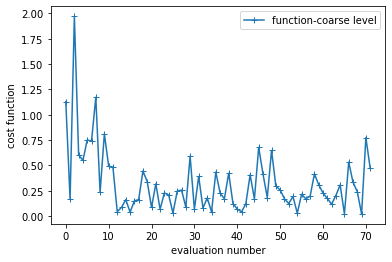

In [20]:
plt.plot(Y[0], label="function-coarse level", marker="+");

plt.xlabel("evaluation number");
plt.ylabel("cost function");
plt.legend();
plt.show();

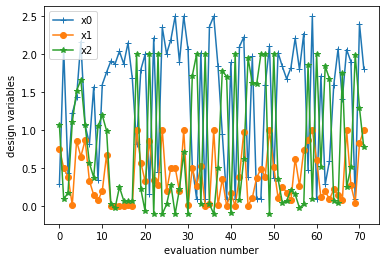

In [21]:
plt.plot(data_X[0][:,0], label="x0", marker="+");
plt.plot(data_X[0][:,1], label="x1", marker="o");
plt.plot(data_X[0][:,2], label="x2", marker="*");
plt.xlabel("evaluation number");
plt.ylabel("design variables");
plt.legend();
plt.show();

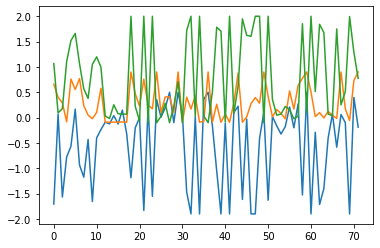

In [22]:
plt.plot(data_X[0]-np.array([[2,0.1,0]]), label='samples')

### fine level evaluations 

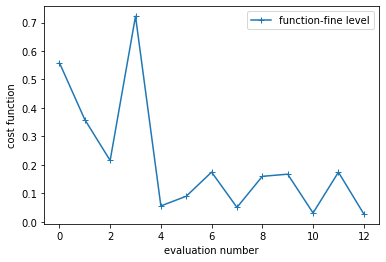

In [23]:
plt.plot(Y[1], label="function-fine level", marker="+");

plt.xlabel("evaluation number");
plt.ylabel("cost function");
plt.legend();
plt.show();

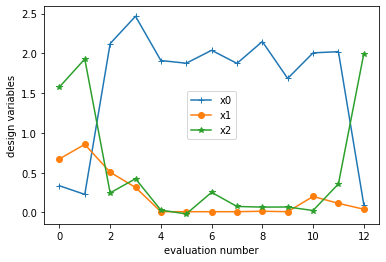

In [25]:
plt.plot(data_X[1][:,0], label="x0", marker="+");
plt.plot(data_X[1][:,1], label="x1", marker="o");
plt.plot(data_X[1][:,2], label="x2", marker="*");
plt.xlabel("evaluation number");
plt.ylabel("design variables");
plt.legend();
plt.show();

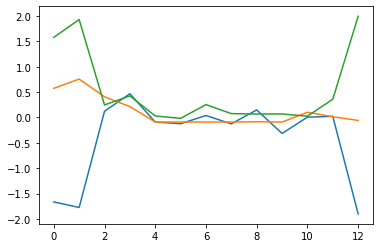

In [24]:
plt.plot(data_X[1]-np.array([[2,0.1,0]]), label='samples')

At the and i run 60 iterations of multi-fidelity EGO.At the end, while exploring , the algorithm needed to compute 60 coarse points and only 9 fine points.


# validation

In [205]:
##validation set using the fine level
num_points=50
##==============================
query_points=search_space.sample(num_points)
##==============================
data=observer_2(query_points)


> evaluation starts ...



real	0m1.979s
user	0m0.481s
sys	0m0.150s


> evaluation done
> evaluation starts ...



real	0m1.969s
user	0m0.452s
sys	0m0.163s


> evaluation done
> evaluation starts ...



real	0m1.938s
user	0m0.450s
sys	0m0.157s


> evaluation done
> evaluation starts ...



real	0m1.570s
user	0m0.092s
sys	0m0.159s


> evaluation done
> evaluation starts ...



real	0m2.574s
user	0m1.093s
sys	0m0.141s


> evaluation done
> evaluation starts ...



real	0m1.758s
user	0m0.234s
sys	0m0.170s


> evaluation done
> evaluation starts ...



real	0m2.662s
user	0m1.136s
sys	0m0.195s


> evaluation done
> evaluation starts ...



real	0m2.132s
user	0m0.626s
sys	0m0.148s


> evaluation done
> evaluation starts ...



real	0m1.940s
user	0m0.459s
sys	0m0.153s


> evaluation done
> evaluation starts ...



real	0m2.581s
user	0m1.111s
sys	0m0.152s


> evaluation done
> evaluation starts ...



real	0m1.599s
user	0m0.111s
sys	0m0.160s


> evaluation done
> evaluation starts ...



real	0m1.816s
user	0m0.348s
sys	0m0.150s


> evaluation done
> evaluation starts ...



real	0m2.473s
user	0m0.967s
sys	0m0.150s


> evaluation done
> evaluation starts ...



real	0m2.152s
user	0m0.665s
sys	0m0.163s


> evaluation done
> evaluation starts ...



real	0m2.535s
user	0m1.048s
sys	0m0.150s


> evaluation done
> evaluation starts ...



real	0m1.629s
user	0m0.132s
sys	0m0.163s


> evaluation done
> evaluation starts ...



real	0m2.296s
user	0m0.767s
sys	0m0.178s


> evaluation done
> evaluation starts ...



real	0m2.006s
user	0m0.523s
sys	0m0.152s


> evaluation done
> evaluation starts ...



real	0m1.830s
user	0m0.347s
sys	0m0.158s


> evaluation done
> evaluation starts ...



real	0m2.146s
user	0m0.624s
sys	0m0.156s


> evaluation done
> evaluation starts ...



real	0m1.960s
user	0m0.447s
sys	0m0.180s


> evaluation done
> evaluation starts ...



real	0m1.884s
user	0m0.386s
sys	0m0.169s


> evaluation done
> evaluation starts ...



real	0m1.654s
user	0m0.099s
sys	0m0.194s


> evaluation done
> evaluation starts ...



real	0m1.983s
user	0m0.506s
sys	0m0.146s


> evaluation done
> evaluation starts ...



real	0m2.101s
user	0m0.590s
sys	0m0.162s


> evaluation done
> evaluation starts ...



real	0m1.972s
user	0m0.477s
sys	0m0.152s


> evaluation done
> evaluation starts ...



real	0m1.925s
user	0m0.398s
sys	0m0.177s


> evaluation done
> evaluation starts ...



real	0m2.007s
user	0m0.509s
sys	0m0.156s


> evaluation done
> evaluation starts ...



real	0m2.201s
user	0m0.676s
sys	0m0.172s


> evaluation done
> evaluation starts ...



real	0m1.665s
user	0m0.155s
sys	0m0.176s


> evaluation done
> evaluation starts ...



real	0m2.129s
user	0m0.622s
sys	0m0.166s


> evaluation done
> evaluation starts ...



real	0m1.637s
user	0m0.134s
sys	0m0.172s


> evaluation done
> evaluation starts ...



real	0m2.248s
user	0m0.765s
sys	0m0.152s


> evaluation done
> evaluation starts ...



real	0m2.518s
user	0m1.054s
sys	0m0.146s


> evaluation done
> evaluation starts ...



real	0m2.322s
user	0m0.798s
sys	0m0.174s


> evaluation done
> evaluation starts ...



real	0m1.843s
user	0m0.340s
sys	0m0.158s


> evaluation done
> evaluation starts ...



real	0m2.312s
user	0m0.818s
sys	0m0.156s


> evaluation done
> evaluation starts ...



real	0m1.997s
user	0m0.532s
sys	0m0.149s


> evaluation done
> evaluation starts ...



real	0m2.425s
user	0m0.908s
sys	0m0.154s


> evaluation done
> evaluation starts ...



real	0m2.553s
user	0m1.049s
sys	0m0.156s


> evaluation done
> evaluation starts ...



real	0m2.025s
user	0m0.546s
sys	0m0.151s


> evaluation done
> evaluation starts ...



real	0m1.596s
user	0m0.100s
sys	0m0.155s


> evaluation done
> evaluation starts ...



real	0m2.522s
user	0m1.018s
sys	0m0.158s


> evaluation done
> evaluation starts ...



real	0m1.882s
user	0m0.383s
sys	0m0.155s


> evaluation done
> evaluation starts ...



real	0m1.706s
user	0m0.198s
sys	0m0.170s


> evaluation done
> evaluation starts ...



real	0m1.616s
user	0m0.105s
sys	0m0.162s


> evaluation done
> evaluation starts ...



real	0m2.403s
user	0m0.891s
sys	0m0.153s


> evaluation done
> evaluation starts ...



real	0m2.351s
user	0m0.849s
sys	0m0.155s


> evaluation done
> evaluation starts ...



real	0m2.448s
user	0m0.951s
sys	0m0.162s


> evaluation done
> evaluation starts ...
> evaluation done



real	0m2.413s
user	0m0.898s
sys	0m0.159s


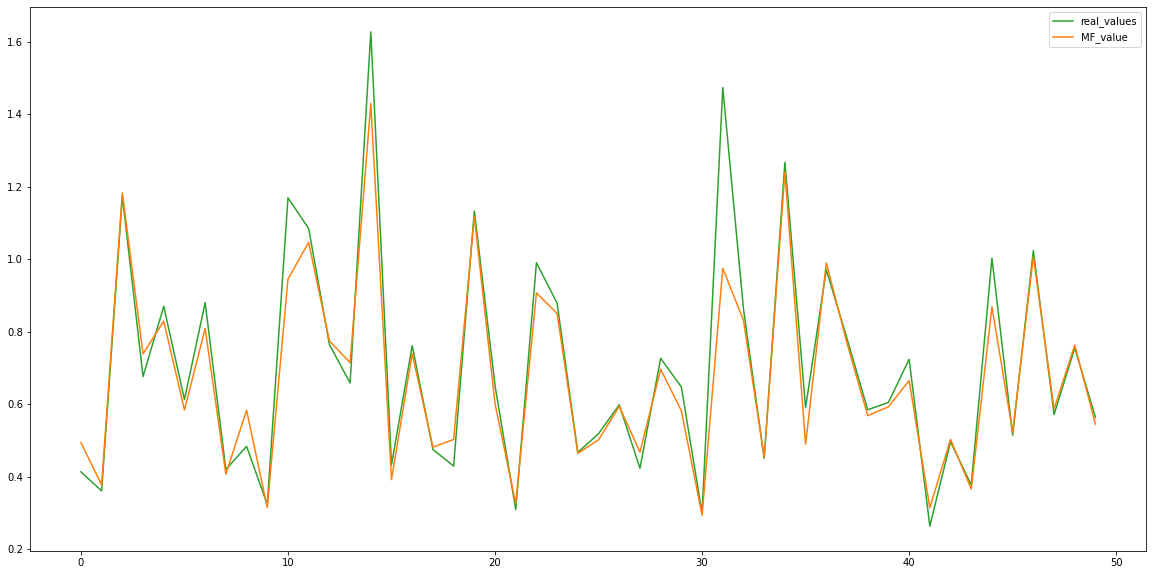

In [207]:
# plt.plot(np.abs(f_hat(data[OBJECTIVE].query_points.numpy()-data[OBJECTIVE].observations)), label='MF_value')
plt.figure(figsize=(20, 10))
# plt.plot(f_hat(data[OBJECTIVE].query_points.numpy()),'C1', label='MF_value')
# plt.plot(f_hat(data[OBJECTIVE].query_points.numpy())-1.96*np.sqrt(sigma_square_hat(data[OBJECTIVE].query_points.numpy())),'C0',label='UV')
# plt.plot(f_hat(data[OBJECTIVE].query_points.numpy())+1.96*np.sqrt(sigma_square_hat(data[OBJECTIVE].query_points.numpy())),'C0',label="LV")
# plt.plot(normalization(data[OBJECTIVE].observations),'C2', label='real_values')
plt.plot(data[OBJECTIVE].observations,'C2', label='real_values')
plt.plot(f_hat(data[OBJECTIVE].query_points.numpy())*(1/2*(Y_max[1]-Y_min[1]))+(1/2*(Y_max[1]+Y_min[1])),'C1', label='MF_value')
plt.legend()

### EGO with Trieste

here i want to compare the points  that the multi-fidelity model uses( on each level seperately) vs the ones found with trieste(simple fidelity on a coarse and then fine mesh) and see the convergence of the cost function 

In [208]:
##  simple fidelity with coarse observations
import trieste
from trieste.models.gpflow import build_gpr, GaussianProcessRegression


def create_bo_model(data):
    gpr = build_gpr(data, search_space, likelihood_variance=1e-7)
    return GaussianProcessRegression(gpr)


initial_models = trieste.utils.map_values(create_bo_model, initial_data_1)
from trieste.acquisition.rule import EfficientGlobalOptimization

pof = trieste.acquisition.ProbabilityOfFeasibility(threshold=Sim.threshold)
eci = trieste.acquisition.ExpectedImprovement(
)
rule = EfficientGlobalOptimization(eci)

num_steps = 60
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer[0], search_space)

data = bo.optimize(
    num_steps, initial_data_1, initial_models, rule, track_state=False
).try_get_final_datasets()

> evaluation starts ...



real	0m1.591s
user	0m0.062s
sys	0m0.162s


> evaluation done
> evaluation starts ...



real	0m1.579s
user	0m0.065s
sys	0m0.188s


> evaluation done
> evaluation starts ...



real	0m1.559s
user	0m0.058s
sys	0m0.171s


> evaluation done
> evaluation starts ...



real	0m1.577s
user	0m0.061s
sys	0m0.168s


> evaluation done
> evaluation starts ...



real	0m1.573s
user	0m0.057s
sys	0m0.176s


> evaluation done
> evaluation starts ...



real	0m1.551s
user	0m0.071s
sys	0m0.155s


> evaluation done
> evaluation starts ...



real	0m1.579s
user	0m0.065s
sys	0m0.161s


> evaluation done
> evaluation starts ...



real	0m1.569s
user	0m0.058s
sys	0m0.177s


> evaluation done
> evaluation starts ...



real	0m1.546s
user	0m0.066s
sys	0m0.163s


> evaluation done
> evaluation starts ...



real	0m1.565s
user	0m0.066s
sys	0m0.160s


> evaluation done
> evaluation starts ...



real	0m1.600s
user	0m0.069s
sys	0m0.166s


> evaluation done
> evaluation starts ...



real	0m1.580s
user	0m0.067s
sys	0m0.168s


> evaluation done
> evaluation starts ...



real	0m1.592s
user	0m0.068s
sys	0m0.157s


> evaluation done
> evaluation starts ...



real	0m1.577s
user	0m0.052s
sys	0m0.170s


> evaluation done
> evaluation starts ...



real	0m1.548s
user	0m0.049s
sys	0m0.171s


> evaluation done
> evaluation starts ...



real	0m1.594s
user	0m0.064s
sys	0m0.187s


> evaluation done
> evaluation starts ...



real	0m1.545s
user	0m0.055s
sys	0m0.162s


> evaluation done
> evaluation starts ...



real	0m1.590s
user	0m0.050s
sys	0m0.197s


> evaluation done
> evaluation starts ...



real	0m1.597s
user	0m0.078s
sys	0m0.177s


> evaluation done
> evaluation starts ...



real	0m1.578s
user	0m0.071s
sys	0m0.163s


> evaluation done
> evaluation starts ...



real	0m1.577s
user	0m0.074s
sys	0m0.163s


> evaluation done
> evaluation starts ...



real	0m1.539s
user	0m0.060s
sys	0m0.156s


> evaluation done
> evaluation starts ...



real	0m1.592s
user	0m0.075s
sys	0m0.174s


> evaluation done
> evaluation starts ...



real	0m1.597s
user	0m0.071s
sys	0m0.166s


> evaluation done
> evaluation starts ...



real	0m1.555s
user	0m0.054s
sys	0m0.169s


> evaluation done
> evaluation starts ...



real	0m1.548s
user	0m0.047s
sys	0m0.166s


> evaluation done
> evaluation starts ...



real	0m1.590s
user	0m0.075s
sys	0m0.172s


> evaluation done
> evaluation starts ...



real	0m1.569s
user	0m0.053s
sys	0m0.175s


> evaluation done
> evaluation starts ...



real	0m1.556s
user	0m0.050s
sys	0m0.166s


> evaluation done
> evaluation starts ...



real	0m1.562s
user	0m0.059s
sys	0m0.170s


> evaluation done
> evaluation starts ...



real	0m1.548s
user	0m0.047s
sys	0m0.174s


> evaluation done
> evaluation starts ...



real	0m1.581s
user	0m0.059s
sys	0m0.177s


> evaluation done
> evaluation starts ...



real	0m1.578s
user	0m0.062s
sys	0m0.156s


> evaluation done
> evaluation starts ...



real	0m1.629s
user	0m0.068s
sys	0m0.157s


> evaluation done
> evaluation starts ...



real	0m1.578s
user	0m0.062s
sys	0m0.160s


> evaluation done
> evaluation starts ...



real	0m1.587s
user	0m0.060s
sys	0m0.164s


> evaluation done
> evaluation starts ...



real	0m1.570s
user	0m0.063s
sys	0m0.155s


> evaluation done
> evaluation starts ...



real	0m1.611s
user	0m0.051s
sys	0m0.194s


> evaluation done
> evaluation starts ...



real	0m1.566s
user	0m0.052s
sys	0m0.175s


> evaluation done
> evaluation starts ...



real	0m1.607s
user	0m0.056s
sys	0m0.169s


> evaluation done
> evaluation starts ...



real	0m1.543s
user	0m0.058s
sys	0m0.167s


> evaluation done
> evaluation starts ...



real	0m1.568s
user	0m0.061s
sys	0m0.151s


> evaluation done
> evaluation starts ...



real	0m1.601s
user	0m0.074s
sys	0m0.177s


> evaluation done
> evaluation starts ...



real	0m1.555s
user	0m0.057s
sys	0m0.165s


> evaluation done
> evaluation starts ...



real	0m1.546s
user	0m0.052s
sys	0m0.161s


> evaluation done
> evaluation starts ...



real	0m1.575s
user	0m0.057s
sys	0m0.166s


> evaluation done
> evaluation starts ...



real	0m1.584s
user	0m0.059s
sys	0m0.176s


> evaluation done
> evaluation starts ...



real	0m1.558s
user	0m0.056s
sys	0m0.169s


> evaluation done
> evaluation starts ...



real	0m1.570s
user	0m0.057s
sys	0m0.170s


> evaluation done
> evaluation starts ...



real	0m1.564s
user	0m0.048s
sys	0m0.175s


> evaluation done
> evaluation starts ...



real	0m1.547s
user	0m0.054s
sys	0m0.173s


> evaluation done
> evaluation starts ...



real	0m1.597s
user	0m0.064s
sys	0m0.183s


> evaluation done
> evaluation starts ...



real	0m1.554s
user	0m0.058s
sys	0m0.163s


> evaluation done
> evaluation starts ...



real	0m1.549s
user	0m0.047s
sys	0m0.170s


> evaluation done
> evaluation starts ...



real	0m1.576s
user	0m0.051s
sys	0m0.159s


> evaluation done
> evaluation starts ...



real	0m1.550s
user	0m0.072s
sys	0m0.155s


> evaluation done
> evaluation starts ...



real	0m1.545s
user	0m0.050s
sys	0m0.172s


> evaluation done
> evaluation starts ...



real	0m1.558s
user	0m0.052s
sys	0m0.159s


> evaluation done
> evaluation starts ...



real	0m1.544s
user	0m0.050s
sys	0m0.160s


> evaluation done
> evaluation starts ...



real	0m1.554s
user	0m0.050s
sys	0m0.161s


> evaluation done
Optimization completed without errors


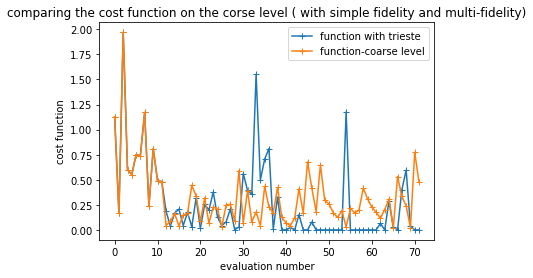

In [209]:

plt.plot(data[OBJECTIVE].observations[:], label="function with trieste", marker="+");
plt.plot(Y[0], label="function-coarse level", marker="+");
plt.xlabel("evaluation number");
plt.ylabel("cost function");
plt.title('comparing the cost function on the corse level ( with simple fidelity and multi-fidelity)')
plt.legend();
plt.show();

In [195]:
## fine simple fidelity 
import trieste
from trieste.models.gpflow import build_gpr, GaussianProcessRegression


def create_bo_model(data):
    gpr = build_gpr(data, search_space, likelihood_variance=1e-7)
    return GaussianProcessRegression(gpr)


initial_models = trieste.utils.map_values(create_bo_model, initial_data_2)
from trieste.acquisition.rule import EfficientGlobalOptimization

pof = trieste.acquisition.ProbabilityOfFeasibility(threshold=Sim.threshold)
eci = trieste.acquisition.ExpectedImprovement(
)
rule = EfficientGlobalOptimization(eci)

num_steps = 10
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer[1], search_space)

data = bo.optimize(
    num_steps, initial_data_2, initial_models, rule, track_state=False
).try_get_final_datasets()

> evaluation starts ...



real	0m2.136s
user	0m0.654s
sys	0m0.149s


> evaluation done
> evaluation starts ...



real	0m2.091s
user	0m0.587s
sys	0m0.155s


> evaluation done
> evaluation starts ...



real	0m2.108s
user	0m0.617s
sys	0m0.160s


> evaluation done
> evaluation starts ...



real	0m2.122s
user	0m0.623s
sys	0m0.169s


> evaluation done
> evaluation starts ...



real	0m2.123s
user	0m0.617s
sys	0m0.161s


> evaluation done
> evaluation starts ...



real	0m2.066s
user	0m0.579s
sys	0m0.154s


> evaluation done
> evaluation starts ...



real	0m2.032s
user	0m0.553s
sys	0m0.159s


> evaluation done
> evaluation starts ...



real	0m2.038s
user	0m0.519s
sys	0m0.161s


> evaluation done
> evaluation starts ...



real	0m2.037s
user	0m0.535s
sys	0m0.153s


> evaluation done
> evaluation starts ...



real	0m2.361s
user	0m0.865s
sys	0m0.155s


> evaluation done
Optimization completed without errors


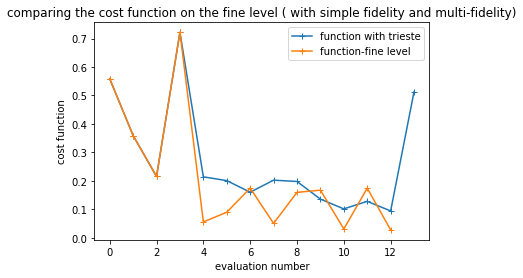

In [196]:

plt.plot(data[OBJECTIVE].observations[:], label="function with trieste", marker="+");
plt.plot(Y[1], label="function-fine level", marker="+");
plt.xlabel("evaluation number");
plt.ylabel("cost function");
plt.title('comparing the cost function on the fine level ( with simple fidelity and multi-fidelity)')
plt.legend();
plt.show();

In [ ]:
## Building a fine simple fidelity model on the same data_set ( i use all the fine points found eventually ) and comparing the predictions on a new set of points 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17624D+02    |proj g|=  1.52379D+02

At iterate    1    f=  1.36650D+01    |proj g|=  2.51914D+01

At iterate    2    f=  8.18142D+00    |proj g|=  1.52147D+01

At iterate    3    f=  3.95955D+00    |proj g|=  5.23099D+00

At iterate    4    f=  3.18644D+00    |proj g|=  2.42143D+00

At iterate    5    f=  2.89259D+00    |proj g|=  1.21084D+00

At iterate    6    f=  2.66215D+00    |proj g|=  1.49964D+00

At iterate    7    f=  2.32523D+00    |proj g|=  1.80488D+00

At iterate    8    f=  1.86893D+00    |proj g|=  2.60561D+00

At iterate    9    f=  1.56413D+00    |proj g|=  1.17064D+00

At iterate   10    f=  1.38170D+00    |proj g|=  3.76182D-01

At iterate   11    f=  1.37317D+00    |proj g|=  9.50200D-02

At iterate   12    f=  1.37221D+00    |proj g|=  8.21030D-02

At iterate   13    f=  1.3

 This problem is unconstrained.


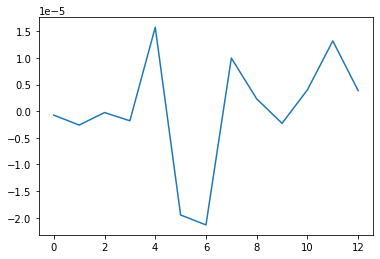

In [210]:
l_HF=[0.1]*dim
k_HF=gpflow.kernels.RBF(1,lengthscales)
high_fidelity_model=gpflow.models.GPR((data_X[1],data_Y[1]),k_HF,noise_variance=1e-5)
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(high_fidelity_model.training_loss,variables=high_fidelity_model.trainable_variables,options=dict(disp=True, maxiter=100))
mean,_=high_fidelity_model.predict_f(data[OBJECTIVE].query_points.numpy())
HF_value,HF_var=high_fidelity_model.predict_f(data_X[1])
plt.plot(HF_value-data_Y[1], 'C0', label='mean')
max_, min_=[np.max(Y[1]), np.min(Y[1])]

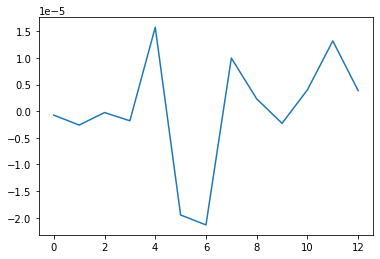

In [204]:
plt.plot(HF_value-data_Y[1], 'C0', label='mean')


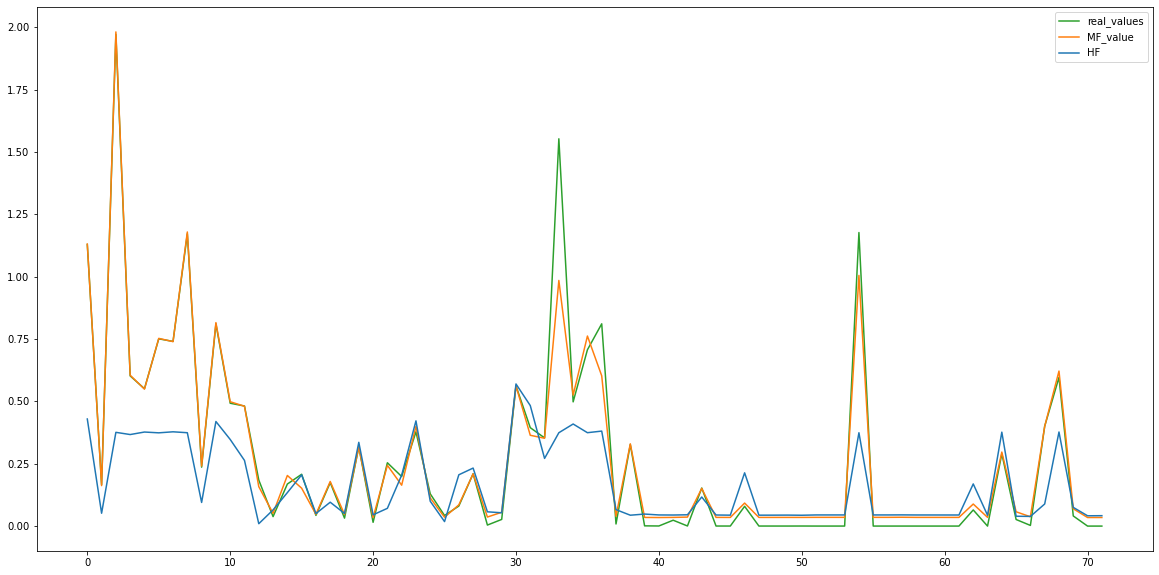

In [211]:
# plt.plot(np.abs(f_hat(data[OBJECTIVE].query_points.numpy()-data[OBJECTIVE].observations)), label='MF_value')
plt.figure(figsize=(20, 10))
plt.plot(data[OBJECTIVE].observations,'C2', label='real_values')
plt.plot(f_hat(data[OBJECTIVE].query_points.numpy())*(1/2*(Y_max[1]-Y_min[1]))+(1/2*(Y_max[1]+Y_min[1])),'C1', label='MF_value')
plt.plot(mean*(1/2*(Y_max[1]-Y_min[1]))+(1/2*(Y_max[1]+Y_min[1])), 'C0', label='HF')
# plt.plot(mean_LF*(1/2*(Y_max[0]-Y_min[0]))+(1/2*(Y_max[0]+Y_min[0])), 'C3', label='LF')
plt.legend()